<CENTER>
</br>
<p><font size="5">  M2MO - XVA Analysis  </font></p>
<p><font size="5">  Project - Gap Risk </font></p>
<p><font size="4">  SANGLIER Nathan & PÉCHEUL Ronan </font></p>
<p><font size="3"></br>April 2025</font></br></div>
<p><span style="color:blue">nathan.sanglier@etu.u-paris.fr, ronan.pecheul@ensae.fr</span>
</p>
</CENTER>

----------------------------

In this project, we focus on computing numerically the CVA of a portfolio made of a unique interest rate swap. We assume the underlying rate process follows Black-Scholes dynamics. First, we derive analytical formulas for the CVA without RIM. We also compute this quantity using linear (neural network) regression and nested Monte-Carlo simulations. We then compute the CVA for a portfolio of one call option using polynomial regression, non-linear neural network regression, and nested Monte-Carlo simulations. The results are validated with the twin Monte-Carlo method. In a second part, we follow the same steps for the CVA with RIM, which involves quantile regression.

## Table of Contents

- [0 - Imports & Parameters](#section-0)
- [I - CVA without RIM](#section-1)
  - [Question 1.1.](#question-1-1)
  - [Question 1.2.](#question-1-2)
  - [Question 1.3.](#question-1-3)
  - [Question 1.4.](#question-1-4)
  - [Question 1.5.](#question-1-5)
- [II - CVA with RIM](#section-2)
  - [Question 2.1.](#question-2-1)
  - [Question 2.2.](#question-2-2)
  - [Question 2.3.](#question-2-3)
  - [Question 2.4.](#question-2-4)
  - [Question 2.5.](#question-2-5)
  - [Question 2.6.](#question-2-6)
- [Conclusion](#conclusion)


## <span id="section-0" style="color:#00B8DE"> 0 - Imports & Parameters </span>

In [1]:
import  torch
import  torch.nn                as      nn
import  numpy                   as      np
import  matplotlib.pyplot       as      plt
from    scipy.stats             import  norm
from    sklearn.linear_model    import  LinearRegression
from    sklearn.preprocessing   import  PolynomialFeatures
from    tqdm                    import  tqdm

In [2]:
np.random.seed(0)
torch.manual_seed(0)

The underlying process of our assets is a rate process $S$ which follows a Black-Scholes model:
$$
\begin{align*}
    dS_t = \kappa S_t dt + \sigma S_t dW_t.
\end{align*}
$$
We set the pricing dates to $t_n = n \delta$, $\forall n \in 0:N_T$, with $N_T = \frac{T}{\delta}$ as we will see that for each pricing date $t$, we need to compute $S_t$ and $S_{t^\delta}$ where $\delta$ is the time between default and portfolio liquidation. Moreover, we assume independent exponential default times with intensity $\gamma$ for the bank and its clients. We first generate $M = 5000$ trajectories of $S$.

In [3]:
r           = 0.02
S0          = 100
kappa       = 0.12
sigma       = 0.2
T           = 5
delta       = 1/52
gamma       = 0.1

time_grid   = np.arange(0, T+delta, delta)
N           = len(time_grid)-1
M           = 5000
M_nmc       = int(np.sqrt(M))

def beta(t):
    return np.exp(-r*t)

In [4]:
def gen_S():
    '''Generate M paths of the underlying asset price'''
    paths           = np.zeros((M, N+1))
    paths[:, 0]     = S0
    Z               = np.random.normal(0, 1, size=(M, N))
    increments      = np.exp((kappa - 0.5 * sigma**2) * delta + sigma * np.sqrt(delta) * Z)
    paths[:, 1:]    = S0 * np.cumprod(increments, axis=1)
    return paths

S_paths = gen_S()

## <span id="section-1" style="color:#00B8DE"> I - CVA without RIM </span>

Let us denote $\text{MtM}$ the mark-to-market process of our asset with underlying $S$ and maturity $T$, so $\text{MtM}_t = 0$ $\forall t > T$. We assume first that the CVA is computed without receiving initial margin. It enables to decrease the FVA, but at the cost of a CVA gap risk. Thus, it is defined at time $0$ as:
$$
\text{CVA}_0 = \gamma \cdot \mathbb{E}\left[\int_0^T \mathbb{E}_t\left[\text{MtM Gap}^+_{t^\delta}\right] e^{-\gamma t} dt\right],
$$
where $\forall t < T$ we have:
$$
\text{MtM Gap}^+_{t^\delta} = \left(\text{MtM Gap}_{t^\delta}\right)^+,
$$
and
$$
\text{MtM Gap}_{t^\delta} = \beta_{t^\delta}(\text{MtM}_{t^\delta} + \Delta_{t^\delta}) - \beta_t \text{MtM}_t,
$$
with $\forall t > T$, $\Delta_t = 0$ so that $\text{MtM Gap}_t = 0$.

### <span style="color:#008000"> Interest Rate Swap

In the following questions, we consider a portfolio made of a unique interest rate swap with a fixed rate $\bar S$ and a notional $\text{Nom}$, and the $\text{MtM}$ process of a long position in this swap is given by $\forall t \le T$:
$$
\text{MtM}_t = \text{Nom} \cdot h \cdot \beta_t^{-1} \cdot \left( \beta_{T_{l_t}}(S_{T_{l_t-1}} - \bar S) + \sum_{l=l_t+1}^d \beta_{T_l} (e^{\kappa T_{l-1}} \hat S_t - \bar S)\right).
$$
$\bar S$ is such that:
$$
\begin{align*}
    \text{MtM}_0 = 0 &\Leftrightarrow  \beta_{T_1} (S_0 - \bar S) + \sum_{l=2}^d \beta_{T_l} (e^{\kappa T_{l-1}} S_0 - \bar S) = 0 \\
    &\Leftrightarrow \bar S = S_0 \cdot \frac{\sum_{l=1}^d \beta_{T_l} e^{\kappa T_{l-1}}}{\sum_{l=1}^d \beta_{T_l}} \approx 134.31.
\end{align*}
$$
Moreover, the nominal of the swap is set so that each leg has a time-$0$ $\text{MtM}$ of one, ie $10^4$ bp:
$$
\begin{align*}
\text{fix leg}_0 = 1 &\Leftrightarrow \text{Nom} \cdot h \cdot \bar S \cdot \sum_{l=1}^d \beta_{T_l} = 1 \\
&\Leftrightarrow \text{Nom} = \frac{1}{h \cdot \bar S \cdot \sum_{l=1}^d \beta_{T_l}} \approx 15.69.
\end{align*}
$$

In [5]:
h                       = 0.25
swap_grid               = np.arange(0, T+h, h)
d                       = len(swap_grid)-1

map_time_to_swap_inds   = np.searchsorted(swap_grid, time_grid, side='right') # l_{t} for t in time_grid
map_swap_to_time_inds   = np.where(np.isin(time_grid, swap_grid))[0] # indices of T_{l} in time_grid

Sbar                    = S0 * np.sum(beta(swap_grid[1:]) * np.exp(kappa*swap_grid[:-1])) / np.sum(beta(swap_grid[1:]))  
nom                     = 10**4 / (h * Sbar * np.sum(beta(swap_grid[1:])))

Let us verify that $\bar S$ and $\text{Nom}$ are well defined by generating $M$ trajectories of $\text{MtM}$ and displaying some statistics.

In [6]:
def gen_mtm_swap(S_paths):
    '''Generate paths of the MtM swap process based on the underlying asset price paths'''
    M   = S_paths.shape[0]
    mtm = np.zeros((M, N+1))
    for i in range(N):
        lt          = map_time_to_swap_inds[i]
        part_sum    = np.sum(beta(swap_grid[lt+1:])*(np.exp(kappa*(swap_grid[lt:-1] - time_grid[i]))*S_paths[:, i].reshape(-1, 1) - Sbar), axis=1)
        mtm[:, i]   = h*nom/beta(time_grid[i]) * (beta(swap_grid[lt])*(S_paths[:, map_swap_to_time_inds[lt-1]] - Sbar) + part_sum)
    return mtm

mtm_swap_paths  = gen_mtm_swap(S_paths)

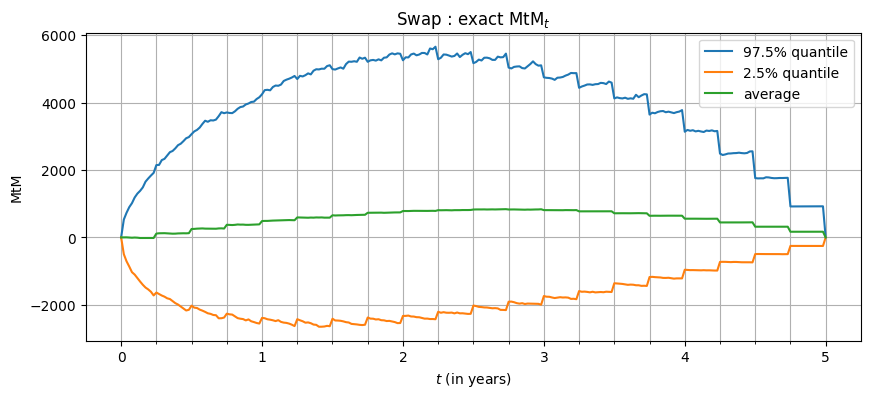

In [7]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(time_grid, np.quantile(mtm_swap_paths, 0.975, axis=0), label='97.5% quantile')
ax.plot(time_grid, np.quantile(mtm_swap_paths, 0.025, axis=0), label='2.5% quantile')
ax.plot(time_grid, np.mean(mtm_swap_paths, axis=0), label='average')
ax.set_xlabel('$t$ (in years)')
ax.set_ylabel('MtM')
ax.set_xticks(swap_grid, minor=True)
ax.grid(which='both')
ax.set_title('Swap : exact $\\text{MtM}_t$')
ax.legend()
plt.show()

We get the same graph as the one presented in the subject.

#### <span id="question-1-1" style="color:#00B8DE"> Question 1.1. </span>

In order to compute the CVA, we want to learn the function $u_t$ for each pricing time $t \le T$  such that:
$$
u_t(S_t) = \mathbb{E}_t\left[\text{MtM Gap}_{t^\delta}^+\right].
$$
In the case of the swap, we won't start from the generic expression of $\text{MtM Gap}$ defined before, but from the following formula (at the cost of a small approximation) $\forall t<T$:
$$
\text{MtM Gap}_{t^\delta}= \text{Nom} \cdot f(t) \cdot (\hat S_{t^\delta} - \hat S_t).
$$

We know that $u_t = \arg\min_{h \in \mathcal{B}} \mathbb{E}\left[\left(\text{MtM Gap}_{t^\delta}^+-h(S_t)\right)^2\right]$ and we will approximate this function with a linear regression model and a one layer linear neural network (for each pricing date). Our data consists of $M$ simulated iid samples of $(S_t^{(m)}, \text{MtM Gap}_{t^\delta}^{+ (m)})$ for each pricing date $t$.

For the linear regression model, we approximate $u_t$ by $\hat u_t^{\text{LR}}(S) = \theta^{\text{LR}}(t) \cdot S$, with $\theta^{\text{LR}}(t)$ being the following OLS estimator:
$$
\begin{align*}
    \theta^{\text{LR}}(t) 
    &= \arg\min_{\theta \in \mathbb{R}} \sum_{m=1}^M \left(\text{MtM Gap}_{t^\delta}^{+ (m)} - \theta \cdot S_t^{(m)}\right)^2, \\
    &= \frac{\sum_{m=1}^M \text{MtM Gap}_{t^\delta}^{+ (m)} \cdot S_t^{(m)}}{\sum_{m=1}^M \left(S_t^{(m)}\right)^2}.
\end{align*}
$$

For the one layer linear neural network, we approximate $u_t$ by $\hat u_t^{\text{LNN}}(S) = \theta^{\text{LNN}}(t) \cdot S$, with $\theta^{\text{LNN}}(t)$ being the following estimator:
$$
\theta^{\text{LNN}}(t) \approx \arg\min_{\theta \in \mathbb{R}} \sum_{m=1}^M \left(\text{MtM Gap}_{t^\delta}^{+ (m)} - h_{\theta}\left(S_t^{(m)}\right)\right)^2,
$$
where $h_{\theta}$ is the neural network function with parameter $\theta$, and the minimization is done with a gradient descent algorithm.

Notice that we use linear models because we have theoretically the following linear relationship for the swap:
$$
\begin{align*}
    \mathbb{E}_t\left[\text{MtM Gap}_{t^\delta}^+\right]
    &= u_t(S_t), \\
    &= \text{Nom} \cdot A(t) \cdot \hat S_t, \notag \\
    &= \theta^{\text{true}}(t) \cdot S_t,
\end{align*}
$$
where $\theta^{\text{true}}(t) = \text{Nom} \cdot A(t) \cdot e^{-\kappa t}$.

Let us first generate our sample trajectories of $\text{MtM Gap}^+$.

In [8]:
def f(i):
    '''Function f(t) at time t_i in the time grid'''
    lt_delta = map_time_to_swap_inds[i+1]
    return h * np.sum(beta(swap_grid[lt_delta+1:])*np.exp(kappa*(swap_grid[lt_delta:-1])))

f_vals = np.array([f(i) for i in range(N)])

def gem_mg_swap(S_paths):
    '''Generates paths of the MtM gap swap process based on the (approximated) formula'''
    mtm_gap = nom*f_vals*np.diff(S_paths*np.exp(-kappa*time_grid), axis=1)
    mtm_gap = np.concatenate((mtm_gap, np.zeros((M, 1))), axis=1)
    return mtm_gap

mg_swap_paths   = gem_mg_swap(S_paths)
mgp_swap_paths  = np.maximum(mg_swap_paths, 0)

We train a linear regression model at each pricing date $t$ using $\left(S_t^{(m)}, \text{MtM Gap}_{t^\delta}^{+ (m)}\right)_m$ and calculate the paths $\left(\hat u_t^{\text{LR}}(S_t)\right)$ for our different trajectories of $(S_t)$.

In [9]:
econd_mgp_swap_lr_paths = np.zeros_like(S_paths)
theta_vals_lr           = np.zeros(N+1)
for i in range(N+1):
    model = LinearRegression(fit_intercept=False)
    model.fit(S_paths[:, i].reshape(-1, 1), mgp_swap_paths[:, i])
    theta_vals_lr[i]                = model.coef_[0]
    econd_mgp_swap_lr_paths[:, i]   = model.predict(S_paths[:, i].reshape(-1, 1))

We do the same for the one layer linear neural network. Notice that for simplicity here, we do not standardize the data as we know we should get a linear relationship with no intercept. Thus, the learning rate of Adam optimizer (a variant of SGD) is set to $5 \cdot 10^{-2}$ to reflect the scale of the data. Notice that we have chosen to reinitialize the weights of the neural network at each pricing date, but we could have chosen to initialize the weights for the next pricing date with the weights of the previous pricing date. It could speed up convergence and avoid local minima but we have chosen to keep the learning process simple to have a better understanding of the results. Moreover, we have taken a small number of epochs mainly as we train on a basic CPU and to prevent overfitting.

In [10]:
class LinearNN(nn.Module):
    def __init__(self, input_dim=1, bias=False):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1, bias=bias)
    def forward(self, x):
        return self.linear(x)

econd_mgp_swap_lnn_paths    = np.zeros_like(S_paths)
theta_vals_lnn              = np.zeros(N+1)
nepochs                     = 100
train_losses_swap_lnn       = np.zeros((N+1, nepochs))
for i in tqdm(range(N), desc='Training linear neural network'):
    x       = torch.tensor(S_paths[:, i].reshape(-1, 1), dtype=torch.float32)
    y       = torch.tensor(mgp_swap_paths[:, i].reshape(-1, 1), dtype=torch.float32)
    model   = LinearNN()
    crit    = nn.MSELoss()
    optim   = torch.optim.Adam(model.parameters(), lr=5*10**(-2))
    for epoch in range(nepochs):
        model.train()
        optim.zero_grad()
        loss = crit(model(x), y)
        loss.backward()
        optim.step()
        train_losses_swap_lnn[i, epoch] = loss.item()
    theta_vals_lnn[i]               = model.linear.weight.item()
    econd_mgp_swap_lnn_paths[:, i]  = model(x).detach().numpy().reshape(-1)

Training linear neural network: 100%|██████████| 260/260 [00:26<00:00,  9.84it/s]


Although not presented here, we have checked that the training losses are decreasing with the number of epochs. One could also check the convergence of the loss function on a validation set, but we have chosen not to display this analysis to keep the notebook concise. Moreover, the training paths are also the ones we do our predictions on, but we could have chosen to have a training set only dedicated to training and not to compute the approximated paths of $\mathbb{E}_t\left[\text{MtM Gap}_{t^\delta}^+\right]$.

#### <span id="question-1-2" style="color:#00B8DE"> Question 1.2. </span>

How to validate our results obtained in the previous question ? First, we can compare $\theta^{LR}$ and $\theta^{LNN}$ with $\theta^{\text{true}}$ for each pricing date $t$ and see if we get the same values. Let us compute the true values of $\theta$ as well as the true paths $(u_t(S_t))$ for our trajectories $(S_t)$ since we have an analytical formula.

In [11]:
def A(i):
    '''Function A(t) at time t_i in the time grid'''
    return f_vals[i] * (norm.cdf(sigma*np.sqrt(delta)/2) - norm.cdf(-sigma*np.sqrt(delta)/2))

A_vals      = np.array([A(i) for i in range(N)])
theta_vals  = nom * A_vals * np.exp(-kappa*time_grid[:-1])
theta_vals  = np.concatenate((theta_vals, np.zeros(1)))

def gen_econd_mgp_swap(S_paths):
    '''Generates paths of the conditional expectation of the postitive part of MtM gap swap process based on the formula'''
    return theta_vals * S_paths

econd_mgp_swap_paths = gen_econd_mgp_swap(S_paths)

For each method, we now display the estimated coefficient $(\theta(t))_t$ of the linear relationship and show the MSE with $(\theta^\text{true}(t))_t$.

MSE theta LNN: 0.0002
MSE theta LR: 0.0002


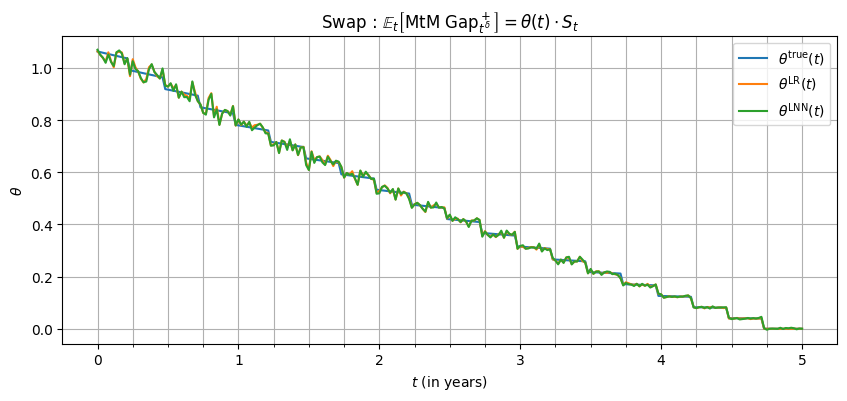

In [12]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(time_grid, theta_vals, label='$\\theta^{\\text{true}}(t)$')
ax.plot(time_grid, theta_vals_lr, label='$\\theta^{\\text{LR}}(t)$')
ax.plot(time_grid, theta_vals_lnn, label='$\\theta^{\\text{LNN}}(t)$')
ax.set_xlabel('$t$ (in years)')
ax.set_ylabel('$\\theta$')
ax.set_xticks(swap_grid, minor=True)
ax.grid(which='both')
ax.set_title('Swap : $\\mathbb{E}_t\\left[\\text{MtM Gap}_{t^\\delta}^+\\right] = \\theta(t) \\cdot S_t$')
ax.legend()
print(f"MSE theta LNN: {np.mean((theta_vals - theta_vals_lnn)**2):.4f}")
print(f"MSE theta LR: {np.mean((theta_vals - theta_vals_lr)**2):.4f}")
plt.show()

We see that the linear regression model and the one layer linear neural network give similar results, meaning that our Adam optimization method converged to the global minimum. We also see that the estimated coefficients are close to the true ones with a low MSE. Still, there is some noise at the beginning which may come from the relatively small size of our dataset. An other explanation is that the feature samples $\left(S_t^{(m)}\right)_m$ for training at date $t$ have less variance at the first pricing dates than at the last ones. Thus, the models may be more sensitive at the beginning. A possible solution would be to generate samples according to uniform distribution for the first pricing dates, but leading a higher computational cost.

If we did not had access to the explicit formula of $\mathbb{E}_t\left[\text{MtM Gap}_{t^\delta}^+\right]$, we could still validate our results with a twin Monte-Carlo method. Indeed, it can be shown that the regression error at time $t$ is given by:
$$
\epsilon_t^2 = \mathbb{E}\left[\left(\mathbb{E}_t\left[\text{MtM Gap}_{t^\delta}^+\right] - \hat u_t(S_t)\right)^2\right]
= \mathbb{E}\left[\hat u_t(S_t)^2 - (\text{MtM Gap}_{t^\delta}^{+ (1)} + \text{MtM Gap}_{t^\delta}^{+ (2)}) \cdot \hat u_t(S_t) + \text{MtM Gap}_{t^\delta}^{+ (1)} \cdot \text{MtM Gap}_{t^\delta}^{+ (2)}\right],
$$
where $\text{MtM Gap}_{t^\delta}^{+ (1)}$ and $\text{MtM Gap}_{t^\delta}^{+ (2)}$ are two iid samples of $\text{MtM Gap}_{t^\delta}^+$ knowing $S_t$:
$$
\text{MtM Gap}_{t^\delta}^{+ (1)/(2)} = \left(\text{MtM Gap}_{t^\delta}^{(1)/(2)}\right)^+,
$$
and
$$
\text{MtM Gap}_{t^\delta}^{(1)/(2)} = \text{Nom} \cdot f(t) \cdot (\hat S_{t^\delta}^{(1)/(2)} - \hat S_t),
$$
with $S_{t^\delta}^{(1)/(2)} = S_t e^{(\kappa - \frac{1}{2} \sigma^2) \delta + \sigma \sqrt{\delta} Z^{(1)/(2)}}$.
We can then approximate the regression error with an empirical mean.

Since the linear regression model and the neural network produce the same results, let us do the analysis for the linear regression model. We first generate the "twin" paths of $\text{MtM Gap}^+$, ie the paths of $\text{MtM Gap}^{+ (2)}$. Notice that we will use for $\text{MtM Gap}^{+ (1)}$ the initial trajectories of $\text{MtM Gap}^+$ so that we only need to generate one sample. We then compute the regression error in the way described above.

In [13]:
def gen_mg_twin_swap(S_paths):
    '''Generates paths of the MtM gap twin swap process'''
    mtm_gap = np.zeros_like(S_paths)
    for i in range(N):
        new_point       = S_paths[:, i]*np.exp((kappa - 0.5*sigma**2)*delta + sigma*np.sqrt(delta)*np.random.normal(0, 1, size=M))
        mtm_gap[:, i]   = nom*f_vals[i]*(np.exp(-kappa*time_grid[i+1])*new_point-np.exp(-kappa*time_grid[i])*S_paths[:, i])
    return mtm_gap

mg_twin_swap_paths  = gen_mg_twin_swap(S_paths)
mgp_twin_swap_paths = np.maximum(mg_twin_swap_paths, 0)
regerr_swap_lr_twin = np.mean(econd_mgp_swap_lr_paths**2 - (mgp_twin_swap_paths+mgp_swap_paths)*econd_mgp_swap_lr_paths + mgp_twin_swap_paths*mgp_swap_paths, axis=0)
regerr_swap_lr_true = np.mean((econd_mgp_swap_lr_paths - econd_mgp_swap_paths)**2, axis=0)

In order to check that our twin Monte-Carlo trick is working well, we can compare the regression error from twin simulation with the "true" regression error. Indeed, we have access to the formula of $\mathbb{E}_t\left[\text{MtM Gap}_{t^\delta}^+\right]$, and we can replace the outer expectation by an empirical mean.

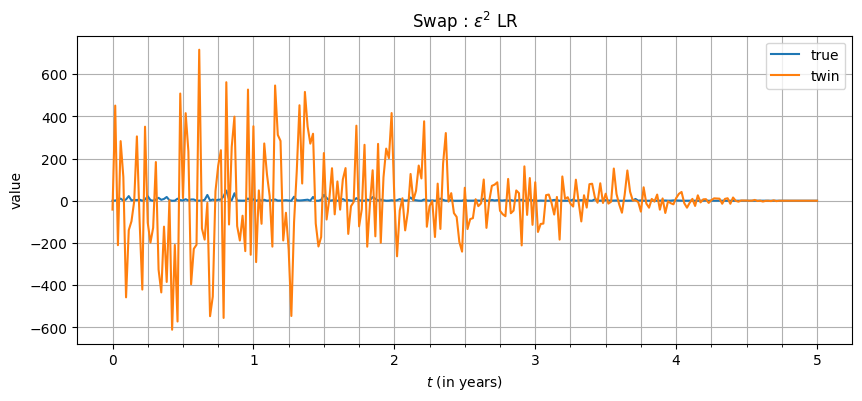

In [14]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(time_grid, regerr_swap_lr_true, label='true')
ax.plot(time_grid, regerr_swap_lr_twin, label='twin')
ax.set_xlabel('$t$ (in years)')
ax.set_ylabel('value')
ax.set_xticks(swap_grid, minor=True)
ax.grid(which='both')
ax.legend()
ax.set_title('Swap : $\\epsilon^2$ LR')
plt.show()

We see that there is an issue with our Monte-Carlo twin method. Indeed, it produces a regression error which is too high and can be negative, and which is not stable when running different simulations. We have tried to generate new (out-of-sample) samples of $\text{MtM Gap}^{+ (1)}$ instead of the ones that were used to train the model, but it does not affect the result. Unfortunately, we did not manage to identify the problem, and it persists in all the other twin simulations of the project.

Finally, we can validate our estimations of $u_t$ by comparing them with a nested Monte-Carlo simulation. This apprach only works for validating one trajectory by one trajectory of the approximated $\mathbb{E}_t\left[\text{MtM Gap}_{t^\delta}\right]$, ie $\hat u_t(S_t)$. Given a trajectory $(S_t)$, we do the following approximation at each pricing date $t$:
$$
\begin{align*}
\mathbb{E}_t\left[\text{MtM Gap}_{t^\delta}^+\right] \approx \frac{1}{K} \sum_{k=1}^K \text{MtM Gap}_{t^\delta}^{+ (k)},
\end{align*}
$$
where $\text{MtM Gap}_{t^\delta}^{+ (k)}$ are $K$ iid samples of $\text{MtM Gap}_{t^\delta}^+$ knowing $S_t$, as for the twin Monte-Carlo method. Thus, we generate $K = \sqrt{M}$ new samples of $\text{MtM Gap}_{t^\delta}^+$ for each pricing date $(t, S_t)$. We did choose $K = \sqrt{M}$ as we will also do a Monte-Carlo simulation for calculating $\text{CVA}_0$ based on the Monte-Carlo simulation of $\mathbb{E}_t\left[\text{MtM Gap}_{t^\delta}^+\right]$ (hence the "nested" term). One can show theoretically that it does not improve the accuracy of CVA to use more than $\sqrt{M}$ samples.

In [15]:
def gen_econd_mgp_swap_nmc(S_paths):
    '''Generates paths of the conditional expectation of the postitive part of MtM gap swap process based on nested Monte Carlo'''
    res = np.zeros_like(S_paths)
    for i in tqdm(range(N), desc='Processing nested Monte Carlo'):
        new_points  = S_paths[:, i]*np.exp((kappa - 0.5*sigma**2)*delta + sigma*np.sqrt(delta)*np.random.normal(0, 1, size=(M_nmc, len(S_paths))))
        res[:, i]   = np.mean(np.maximum(nom*f_vals[i]*(np.exp(-kappa*time_grid[i+1])*new_points-np.exp(-kappa*time_grid[i])*S_paths[:, i]), 0), axis=0)
    return res

econd_mgp_swap_nmc_paths = gen_econd_mgp_swap_nmc(S_paths)

Processing nested Monte Carlo: 100%|██████████| 260/260 [00:03<00:00, 67.13it/s]


Let us display statistics of our estimates of $u_t(S_t)$.

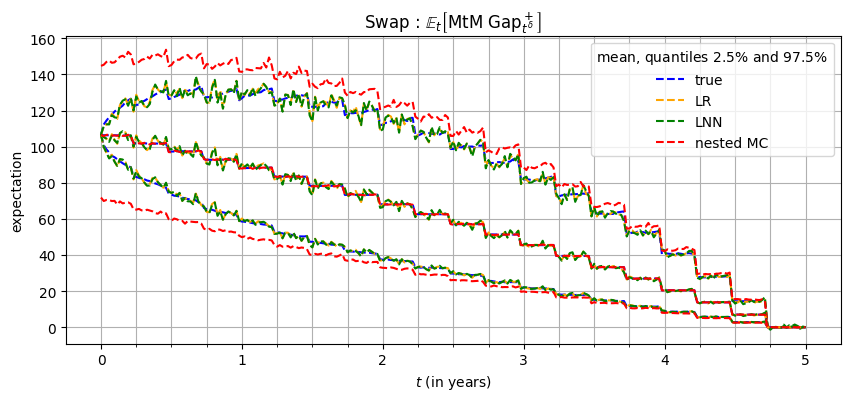

In [16]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(time_grid, np.quantile(econd_mgp_swap_paths, 0.975, axis=0), label='true', linestyle='--', color='blue')
ax.plot(time_grid, np.quantile(econd_mgp_swap_lr_paths, 0.975, axis=0), label='LR', linestyle='--', color='orange')
ax.plot(time_grid, np.quantile(econd_mgp_swap_lnn_paths, 0.975, axis=0), label='LNN', linestyle='--', color='green')
ax.plot(time_grid, np.quantile(econd_mgp_swap_nmc_paths, 0.975, axis=0), label='nested MC', linestyle='--', color='red')

ax.plot(time_grid, np.quantile(econd_mgp_swap_paths, 0.025, axis=0), linestyle='--', color='blue')
ax.plot(time_grid, np.quantile(econd_mgp_swap_lr_paths, 0.025, axis=0), linestyle='--', color='orange')
ax.plot(time_grid, np.quantile(econd_mgp_swap_lnn_paths, 0.025, axis=0), linestyle='--', color='green')
ax.plot(time_grid, np.quantile(econd_mgp_swap_nmc_paths, 0.025, axis=0), linestyle='--', color='red')

ax.plot(time_grid, np.mean(econd_mgp_swap_paths, axis=0), linestyle='--', color='blue')
ax.plot(time_grid, np.mean(econd_mgp_swap_lr_paths, axis=0), linestyle='--', color='orange')
ax.plot(time_grid, np.mean(econd_mgp_swap_lnn_paths, axis=0), linestyle='--', color='green')
ax.plot(time_grid, np.mean(econd_mgp_swap_nmc_paths, axis=0), linestyle='--', color='red')
ax.set_xlabel('$t$ (in years)')
ax.set_ylabel('expectation')
ax.set_xticks(swap_grid, minor=True)
ax.grid(which='both')
ax.set_title('Swap : $\\mathbb{E}_t\\left[\\text{MtM Gap}_{t^\\delta}^+\\right]$')
ax.legend(title='mean, quantiles $2.5\\%$ and $97.5\\%$')
plt.show()

We see that the estimations using linear regression model or the linear neural network are close to the ground truth, but more noisy (as observed in the coefficient $\theta(t)$). We have checked that a higher number of samples reduces this noise. Moreover, the nested Monte-Carlo method seems to produce more variance, especially for the first pricing dates. It was expected as the linear regression model and the neural network are trained with the feature being $S_t$, while the nested Monte Carlo explictly computes $\text{MtM Gap}_{t^\delta}^+$ and it based on less samples, yielding to greater variance.

#### <span id="question-1-3" style="color:#00B8DE"> Question 1.3. </span>

Now, the CVA can be computed using our previous estimators $\hat u_t(S_t)$ of $\mathbb{E}_t\left[\text{MtM Gap}_{t^\delta}\right]$, approximating the integral numerically and taking an empirical mean over our $M$ iid samples $\hat u_t(S_t^{(m)})$.

Notice that we can validate our results using empirical mean for the outer expecation and the formula or nested Monte-Carlo simulation for the inner conditional expectation, but also using the following formula for a swap:
$$
\text{CVA}_0 = \text{Nom} \cdot S_0 \cdot \gamma \cdot \int_0^T A(t) \cdot e^{-\gamma t} dt.
$$

In [17]:
cva_swap = nom*S0*np.trapezoid(A_vals * np.exp(-gamma*time_grid[:-1]) * gamma, dx=delta)

In [18]:
def calc_cva(econd_mgp_paths):
    'Calculates the CVA based on the estimation of conditional expectation of the MtM gap process'
    CVA_vals = np.trapezoid(econd_mgp_paths[:, :-1] * np.exp(-gamma*time_grid[:-1]) * gamma, dx=delta, axis=1)
    return np.mean(CVA_vals)

cva_swap_mc     = calc_cva(econd_mgp_swap_paths)
cva_swap_lr     = calc_cva(econd_mgp_swap_lr_paths)
cva_swap_lnn    = calc_cva(econd_mgp_swap_lnn_paths)
cva_swap_nmc    = calc_cva(econd_mgp_swap_nmc_paths)

print(f"CVA swap formula: {cva_swap:.4f}")
print(f"CVA swap using MC for outer expectation and formula for conditional expectation: {cva_swap_mc:.4f}")
print(f"CVA swap using MC for outer expectation and LR for conditional expectation: {cva_swap_lr:.4f}")
print(f"CVA swap using MC for outer expectation and LNN for conditional expectation: {cva_swap_lnn:.4f}")
print(f"CVA swap using MC for outer expectation and nested MC for conditional expectation: {cva_swap_nmc:.4f}")

CVA swap formula: 24.0534
CVA swap using MC for outer expectation and formula for conditional expectation: 24.1339
CVA swap using MC for outer expectation and LR for conditional expectation: 24.1530
CVA swap using MC for outer expectation and LNN for conditional expectation: 24.1252
CVA swap using MC for outer expectation and nested MC for conditional expectation: 24.1292


All the estimated CVA have the same magnitude as the true one, with the CVA estimated using linear regression being close to the one estimated using the neural network. Although the nested Monte-Carlo method produces had higher variance for $\mathbb{E}_t\left[\text{MtM Gap}_{t^\delta}\right]$, it produces a CVA estimate close to the true one as expected.

### <span style="color:#008000"> Interest Rate Call Option

In the following questions, we consider a portfolio made of an interest rate call option ATM $(K=S_0)$ instead of the swap. The MtM process of a long position in this call option is given by the well-known Black-Scholes formula $\forall t < T$:
$$
\text{MtM}_t = e^{-r (T-t)} \left(e^{\kappa (T-t)} S_t \mathcal{N}(d_+) - S_0 \mathcal{N}(d_-)\right),
$$
with $d_\pm = \frac{\log(S_t/S_0) + (\kappa \pm \frac{1}{2} \sigma^2)(T-t)}{\sigma \sqrt{T-t}}$. We assumed a nominal of $1$, but we could have taken the same nominal as for the swap.

#### <span id="question-1-4" style="color:#00B8DE"> Question 1.4. </span>

In the case of the call, we do not have anymore the explicit formulas for verfying our estimations of $\mathbb{E}_t\left[\text{MtM Gap}_{t^\delta}^+\right]$ and $\text{CVA}_0$. Moreover, we will start from the generic expression of $\text{MtM Gap}$, but noticing $\Delta_{t^\delta} = 0$:
$$
\text{MtM Gap}_{t^\delta} = \left(\beta_{t^\delta} \text{MtM}_{t^\delta} - \beta_t \text{MtM}_t\right),
$$
with $\text{MtM}$ given as above.

We do not expect to have a linear function $u_t(S_t) = \mathbb{E}_t\left[\text{MtM Gap}^+_{t^\delta}\right]$ anymore. Thus, we will approximate this function with a polynomial regression model and a non-linear neural network. Our results will be validated with twin Monte-Carlo method and nested Monte-Carlo simulation, as in the previous questions (but loosing analytical formulas).

Let us first generate our sample trajectories of $\text{MtM Gap}^+$.

In [19]:
def gen_mtm_call(S_paths):
    '''Generate paths of the MtM call process based on the underlying asset price paths'''
    M   = S_paths.shape[0]
    MtM = np.zeros((M, N+1))
    for i in range(N):
        d1          = (np.log(S_paths[:, i]/S0) + (kappa + 0.5*sigma**2)*(T-time_grid[i])) / (sigma*np.sqrt(T-time_grid[i]))
        d2          = d1 - sigma*np.sqrt(T-time_grid[i])
        MtM[:, i]   = np.exp(-r*(T-time_grid[i]))*(S_paths[:, i]*np.exp(kappa*(T-time_grid[i]))*norm.cdf(d1) - S0*norm.cdf(d2))
    MtM[:, N] = np.maximum(S_paths[:, N] - S0, 0)
    return MtM

def gen_mg_call(mtm_paths):
    '''Generates paths of the positive part of the MtM gap call process based on definition of MtM gap'''
    return np.concatenate((np.diff(beta(time_grid)*mtm_paths), np.zeros((M, 1))), axis=1)

mtm_call_paths  = gen_mtm_call(S_paths)
mg_call_paths   = gen_mg_call(mtm_call_paths)
mgp_call_paths  = np.maximum(mg_call_paths, 0)

We train a polynomial regression model of degree $3$ (can be fine-tuned) at each pricing date $t$ using $\left(S_t^{(m)}, \text{MtM Gap}_{t^\delta}^{+ (m)}\right)_m$ and calculate the paths $\left(u_t^{\text{PR}}(S_t)\right)$ for our different trajectories of $(S_t)$.

In [20]:
econd_mgp_call_pr_paths = np.zeros((M, N+1))
for i in range(N):
    model   = LinearRegression(fit_intercept=False)
    poly    = PolynomialFeatures(degree=3, include_bias=True)
    S_poly  = poly.fit_transform(S_paths[:, i].reshape(-1, 1))
    model.fit(S_poly, mgp_call_paths[:, i])
    econd_mgp_call_pr_paths[:, i] = model.predict(S_poly)

We do the same for the non-linear neural network, producing $\left(u_t^{\text{NLNN}}(S_t)\right)$. We have chosen a neural network with one hidden layer of $10$ neurons, ReLU activation function, and Adam optimizer. We did not try to optimize the hyperparamters of this architecture, but doing so could increase the performances. Notice that here we standardize the data and initialize the weights for the next pricing date with the weights of the previous pricing date.

In [21]:
class NonLinearNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.hidden     = nn.Linear(input_dim, 10)
        self.output     = nn.Linear(10, 1)
        self.activation = nn.ReLU()
    def forward(self, x):
        x = self.activation(self.hidden(x))
        x = self.output(x)
        return x

econd_mgp_call_nlnn_paths   = np.zeros((M, N+1))
nepochs                     = 200
train_losses_call_nlnn      = np.zeros((N+1, nepochs))
model   = NonLinearNN(input_dim=1)
for i in tqdm(range(N), desc='Training nonlinear neural network'):
    x       = torch.tensor(S_paths[:, i].reshape(-1, 1), dtype=torch.float32)
    x       = (x - x.mean())/x.std() if x.std() > 0 else x
    y       = torch.tensor(mgp_call_paths[:, i].reshape(-1, 1), dtype=torch.float32)
    crit    = nn.MSELoss()
    optim   = torch.optim.Adam(model.parameters(), lr=10**(-2))
    for epoch in range(nepochs):
        model.train()
        optim.zero_grad()
        loss = crit(model(x), y)
        loss.backward()
        optim.step()
        train_losses_call_nlnn[i, epoch] = loss.item()
    econd_mgp_call_nlnn_paths[:, i] = model(x).detach().numpy().reshape(-1)

Training nonlinear neural network: 100%|██████████| 260/260 [01:19<00:00,  3.29it/s]


Let us validate our results with a twin Monte-Carlo method as in [Question 1.2.](#question-1-2). Notice that here, contrary to the swap, we do not have access to the "true" regression error as we do not have explicit expression for $\mathbb{E}_t\left[\text{MtM Gap}_{t^\delta}^+\right]$.

In [22]:
def gen_mg_twin_call(S_paths):
    mtm_gap = np.zeros_like(S_paths)
    for i in range(N):
        d1              = (np.log(S_paths[:, i]/S0) + (kappa + 0.5*sigma**2)*(T-time_grid[i])) / (sigma*np.sqrt(T-time_grid[i]))
        d2              = d1 - sigma*np.sqrt(T-time_grid[i])
        mtm             = np.exp(-r*(T-time_grid[i]))*(S_paths[:, i]*np.exp(kappa*(T-time_grid[i]))*norm.cdf(d1) - S0*norm.cdf(d2))
        new_point       = S_paths[:, i]*np.exp((kappa - 0.5*sigma**2)*delta + sigma*np.sqrt(delta)*np.random.normal(0, 1, size=M))
        new_mtm         = np.exp(-r*(T-time_grid[i+1]))*(new_point*np.exp(kappa*(T-time_grid[i+1]))*norm.cdf(d1) - S0*norm.cdf(d2))
        mtm_gap[:, i]   = beta(time_grid[i+1])*new_mtm - beta(time_grid[i])*mtm
    return mtm_gap

mg_twin_call_paths  = gen_mg_twin_call(S_paths)
mgp_twin_call_paths = np.maximum(mg_twin_call_paths, 0)
regerr_call_pr_twin = np.mean(econd_mgp_call_pr_paths**2 - (mgp_twin_call_paths+mgp_call_paths)*econd_mgp_call_pr_paths + mgp_twin_call_paths*mgp_call_paths, axis=0)

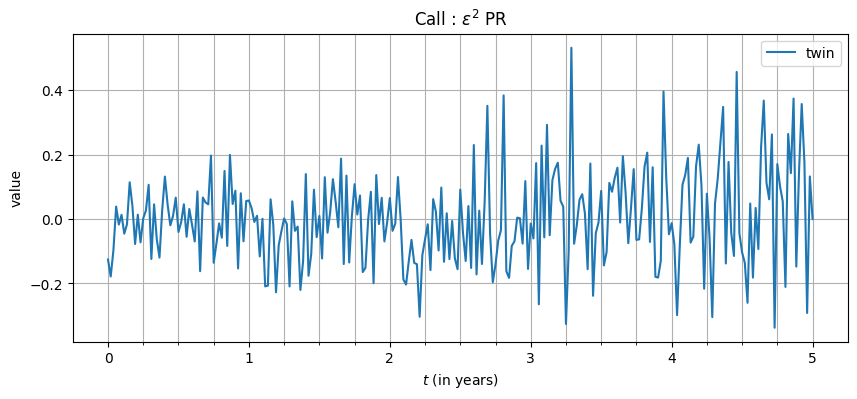

In [23]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(time_grid, regerr_call_pr_twin, label='twin')
ax.set_xlabel('$t$ (in years)')
ax.set_ylabel('value')
ax.set_xticks(swap_grid, minor=True)
ax.grid(which='both')
ax.set_title('Call : $\\epsilon^2$ PR')
ax.legend()
plt.show()

Again and as explained before, there is still an issue with our Monte-Carlo twin method (regression error negative).

Finally, we can validate our estimations of $u_t$ by comparing them with a nested Monte-Carlo simulation.

In [24]:
def gen_econd_mgp_call_nmc(S_paths):
    res = np.zeros_like(S_paths)
    for i in tqdm(range(N), desc='Processing nested Monte Carlo'):
        d1          = (np.log(S_paths[:, i]/S0) + (kappa + 0.5*sigma**2)*(T-time_grid[i])) / (sigma*np.sqrt(T-time_grid[i]))
        d2          = d1 - sigma*np.sqrt(T-time_grid[i])
        mtm         = np.exp(-r*(T-time_grid[i]))*(S_paths[:, i]*np.exp(kappa*(T-time_grid[i]))*norm.cdf(d1) - S0*norm.cdf(d2))
        new_points  = S_paths[:, i]*np.exp((kappa - 0.5*sigma**2)*delta + sigma*np.sqrt(delta)*np.random.normal(0, 1, size=(M_nmc, len(S_paths))))
        if i == N-1:
            new_mtms    = np.maximum(new_points - S0, 0) # t = t_N --> MtM = call payoff
        else:
            d1          = (np.log(new_points/S0) + (kappa + 0.5*sigma**2)*(T-time_grid[i+1])) / (sigma*np.sqrt(T-time_grid[i+1]))
            d2          = d1 - sigma*np.sqrt(T-time_grid[i+1])
            new_mtms    = np.exp(-r*(T-time_grid[i+1]))*(new_points*np.exp(kappa*(T-time_grid[i+1]))*norm.cdf(d1) - S0*norm.cdf(d2))
        new_gap     = beta(time_grid[i+1])*new_mtms - beta(time_grid[i])*mtm
        res[:, i]   = np.mean(np.maximum(new_gap, 0), axis=0)
    return res

econd_mgp_call_nmc_paths = gen_econd_mgp_call_nmc(S_paths)

Processing nested Monte Carlo: 100%|██████████| 260/260 [00:16<00:00, 15.91it/s]


Let us display statistics of our estimates of $u_t(S_t)$.

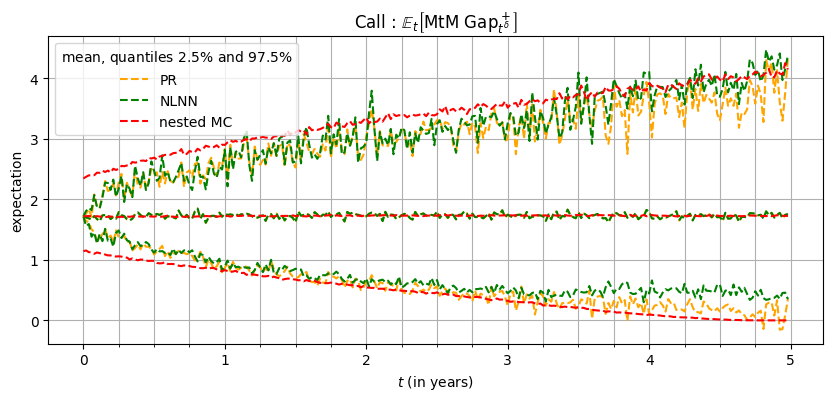

In [25]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(time_grid[:-1], np.quantile(econd_mgp_call_pr_paths, 0.975, axis=0)[:-1], label='PR', linestyle='--', color='orange')
ax.plot(time_grid[:-1], np.quantile(econd_mgp_call_nlnn_paths, 0.975, axis=0)[:-1], label='NLNN', linestyle='--', color='green')
ax.plot(time_grid[:-1], np.quantile(econd_mgp_call_nmc_paths, 0.975, axis=0)[:-1], label='nested MC', linestyle='--', color='red')

ax.plot(time_grid[:-1], np.quantile(econd_mgp_call_pr_paths, 0.025, axis=0)[:-1], linestyle='--', color='orange')
ax.plot(time_grid[:-1], np.quantile(econd_mgp_call_nlnn_paths, 0.025, axis=0)[:-1], linestyle='--', color='green')
ax.plot(time_grid[:-1], np.quantile(econd_mgp_call_nmc_paths, 0.025, axis=0)[:-1], linestyle='--', color='red')

ax.plot(time_grid[:-1], np.mean(econd_mgp_call_pr_paths, axis=0)[:-1], linestyle='--', color='orange')
ax.plot(time_grid[:-1], np.mean(econd_mgp_call_nlnn_paths, axis=0)[:-1], linestyle='--', color='green')
ax.plot(time_grid[:-1], np.mean(econd_mgp_call_nmc_paths, axis=0)[:-1], linestyle='--', color='red')
ax.set_xlabel('$t$ (in years)')
ax.set_ylabel('expectation')
ax.set_xticks(swap_grid, minor=True)
ax.grid(which='both')
ax.set_title('Call : $\\mathbb{E}_t\\left[\\text{MtM Gap}_{t^\\delta}^+\\right]$')
ax.legend(title='mean, quantiles $2.5\\%$ and $97.5\\%$')
plt.show()

We see that the estimations using polynomial regression model or the linear neural network are similar. However, they are less smooth compared to the swap case, but this can be attenuated with more samples. We find the same behavior for the nested Monte-Carlo method as for the swap case.

#### <span id="question-1-5" style="color:#00B8DE"> Question 1.5. </span>

As in [Question 1.3.](#question-1-3), the CVA can be computed using our previous estimators $\hat u_t(S_t)$ of $\mathbb{E}_t\left[\text{MtM Gap}_{t^\delta}\right]$, approximating the integral numerically, and taking an empirical mean over our $M$ iid samples $\hat u_t(S_t^{(m)})$.

Notice that we can validate our results using empirical mean for the outer expecation and nested Monte-Carlo simulation for the inner conditional expectation, but also using the following Monte-Carlo companion procedure (because we just need to compute CVA at time $t=0$):
$$
\begin{align*}
    \text{CVA}_0
    &= \gamma \cdot \mathbb{E}\left[\int_0^T \mathbb{E}_t\left[\text{MtM Gap}^+_{t^\delta}\right] e^{-\gamma t} dt\right], \\
    &= \gamma \cdot \int_0^T \mathbb{E}\left[\text{MtM Gap}^+_{t^\delta}\right] e^{-\gamma t} dt, \\
    &\approx \gamma \cdot \int_0^T \frac{1}{M} \sum_{m=1}^M \text{MtM Gap}_{t^\delta}^{+ (m)} e^{-\gamma t} dt.
\end{align*}
$$
Thus, for computing only $\text{CVA}_0$ without RIM, it was in reality unnecessary to learn the conditional expectation $\mathbb{E}_t\left[\text{MtM Gap}^+_{t^\delta}\right]$.

In [26]:
cva_call_cmc    = np.trapezoid(np.mean(mgp_call_paths[:, :-1], axis=0) * np.exp(-gamma*time_grid[:-1]) * gamma, dx=delta)
cva_call_pr     = calc_cva(econd_mgp_call_pr_paths)
cva_call_nlnn   = calc_cva(econd_mgp_call_nlnn_paths)
cva_call_nmc    = calc_cva(econd_mgp_call_nmc_paths)    

print(f"CVA call using companion MC: {cva_call_cmc:.4f}")
print(f"CVA call using MC for outer expectation and PR for conditional expectation: {cva_call_pr:.4f}")
print(f"CVA call using MC for outer expectation and NLNN for conditional expectation: {cva_call_nlnn:.4f}")
print(f"CVA call using MC for outer expectation and nested MC for conditional expectation: {cva_call_nmc:.4f}")

CVA call using companion MC: 0.6782
CVA call using MC for outer expectation and PR for conditional expectation: 0.6782
CVA call using MC for outer expectation and NLNN for conditional expectation: 0.6782
CVA call using MC for outer expectation and nested MC for conditional expectation: 0.6778


We see that with our estimations, we perfectly estimate the CVA with respect to to the companion Monte-Carlo (unbiased) procedure which can be seen as ground truth for a sufficiently high number of samples.

## <span id="section-2" style="color:#00B8DE"> II - CVA with RIM </span>

We now assume the CVA is computed by taking into account the initial margin received from counterparty (RIM). We will see that it enables to erode gap risk and the ensuing CVA. Thus, it is defined at time $0$ as:
$$
\text{CVA}^{\text{rim}}_0 = \gamma \cdot \mathbb{E}\left[\int_0^T \mathbb{E}_t\left[\text{MtM Gap}^{\text{rim} +}_{t^\delta}\right] e^{-\gamma t} dt\right],
$$
where $\forall t < T$ we have:
$$
\text{MtM Gap}^{\text{rim} +}_{t^\delta} = \left(\text{MtM Gap}^{\text{rim}}_{t^\delta}\right)^+,
$$
and
$$
\begin{align*}
    \text{MtM Gap}^{\text{rim}}_{t^\delta}
    &= \beta_{t^\delta}(\text{MtM}_{t^\delta} + \Delta_{t^\delta}) - \beta_t (\text{MtM}_t + \text{RIM}_t),
\end{align*}
$$
with $\text{MtM Gap}^{\text{rim}}_{T^\delta} = 0$. Moreover,
$$
\beta_t \text{RIM}_t = \left(\mathbb{V}\text{a}\mathbb{R}_t^a(\beta_{t^\delta}(\text{MtM}_{t^\delta} + \Delta_{t^\delta}) - \beta_t \text{MtM}_t)\right)^+.
$$

### <span style="color:#008000"> Interest Rate Swap

#### <span id="question-2-1" style="color:#00B8DE"> Question 2.1. </span>

First, let us show that
$$
\begin{align*}
\mathbb{E}_t\left[\text{MtM Gap}^{\text{rim} +}_{t^\delta}\right]
&= \text{Nom} \cdot C(t) \cdot \hat S_t \\
&= \rho^{\text{true}}(t) \cdot S_t,
\end{align*}
$$
where $\rho^{\text{true}}(t) = \text{Nom} \cdot C(t) \cdot e^{-\kappa t}$ and:
$$
\begin{align*}
C(t)
&= (1-a) \cdot f(t) \cdot e^{-\frac{\sigma^2 \delta}{2}} \cdot \left(\frac{\Phi\left(\sigma\sqrt{\delta} - \Phi^{-1}(a)\right)}{1-a} e^\frac{\sigma^2 \delta}{2} - e^{\sigma \sqrt{\delta} \Phi^{-1}(a)}\right).
\end{align*}
$$
Notice that we have a different formula than the one in the subject where $\frac{\Phi\left(\sigma\sqrt{\delta} - \Phi^{-1}(a)\right)}{1-a} e^\frac{\sigma^2 \delta}{2}$ should be replaced by $e^{\sigma \sqrt{\delta} \frac{\phi(\Phi^{-1}(a))}{1-a}}$. Indeed, we were not able to derive this expression and we believe that the formula in the subject is incorrect. However, it appears that the two expressions are very close numerically.



<u>Proof</u>: We have:
$$
\begin{align*}
\mathbb{E}_t\left[\text{MtM Gap}^{\text{rim} +}_{t^\delta}\right]
&= \mathbb{E}_t\left[\left(\text{MtM Gap}_{t^\delta} - \mathbb{V}\text{a}\mathbb{R}_t^a\left(\text{MtM Gap}_{t^\delta}\right)^+\right)^+\right] \\
&= \mathbb{E}_t\left[\text{MtM Gap}_{t^\delta} \mathbf{1}_{\text{MtM Gap}_{t^\delta} \ge \mathbb{V}\text{a}\mathbb{R}_t^a\left(\text{MtM Gap}_{t^\delta}\right)^+}\right] - \mathbb{V}\text{a}\mathbb{R}_t^a\left(\text{MtM Gap}_{t^\delta}\right)^+ \mathbb{Q}_t\left(\text{MtM Gap}_{t^\delta} \ge \mathbb{V}\text{a}\mathbb{R}_t^a\left(\text{MtM Gap}_{t^\delta}\right)^+\right), \\
\end{align*}
$$
where $\mathbb{Q}_t$ is the probability conditional to $\mathcal{F}_t$. Assuming $\mathbb{V}\text{a}\mathbb{R}_t^a\left(\text{MtM Gap}_{t^\delta}\right)^+ \ge 0$ yields:
$$
\begin{align*}
\mathbb{E}_t\left[\text{MtM Gap}^{\text{rim} +}_{t^\delta}\right]
&= (1-a) \cdot \left(\mathbb{ES}_t^a(\text{MtM Gap}_{t^\delta}) - \mathbb{V}\text{a}\mathbb{R}_t^a\left(\text{MtM Gap}_{t^\delta}\right)\right).
\end{align*}
$$
Then, we have:
$$
\begin{align*}
\mathbb{V}\text{a}\mathbb{R}_t^a\left(\text{MtM Gap}_{t^\delta}\right)
&= \text{Nom} \cdot f(t)  \cdot \mathbb{V}\text{a}\mathbb{R}_t^a\left(\hat S_{t^\delta} - \hat S_t\right) \\
&= \text{Nom} \cdot f(t)  \cdot \hat S_t \cdot \mathbb{V}\text{a}\mathbb{R}_t^a\left(e^{-\frac{\sigma^2 \delta}{2} + \sigma\sqrt{\delta} Z}-1\right) \\
&= \text{Nom} \cdot f(t)  \cdot \hat S_t \cdot \left(e^{-\frac{\sigma^2 \delta}{2}} \mathbb{V}\text{a}\mathbb{R}_t^a\left(e^{\sigma\sqrt{\delta} Z}\right)-1\right) \\
&= \text{Nom} \cdot f(t)  \cdot \hat S_t \cdot \left(e^{-\frac{\sigma^2 \delta}{2} + \sigma\sqrt{\delta}\Phi^{-1}(a)}-1\right) \\
&= \lambda^{\text{true}}(t) \cdot S_t,
\end{align*}
$$
where $\lambda^{\text{true}}(t) = \text{Nom} \cdot f(t)  \cdot e^{- \kappa t} \left(e^{-\frac{\sigma^2 \delta}{2} + \sigma\sqrt{\delta}\Phi^{-1}(a)}-1\right)$ and $Z \sim \mathcal{N}(0,1)$. Moreover,
$$
\begin{align*}
\mathbb{ES}_t^a(\text{MtM Gap}_{t^\delta})
&= \text{Nom} \cdot f(t)  \cdot \mathbb{ES}_t^a\left(\hat S_{t^\delta} - \hat S_t\right) \\
&= \text{Nom} \cdot f(t)  \cdot \hat S_t \cdot \mathbb{ES}_t^a\left(e^{-\frac{\sigma^2 \delta}{2} + \sigma\sqrt{\delta} Z}-1\right) \\
&= \text{Nom} \cdot f(t)  \cdot \hat S_t \cdot \left(e^{-\frac{\sigma^2 \delta}{2}} \mathbb{ES}_t^a\left(e^{\sigma\sqrt{\delta} Z}\right)-1\right).
\end{align*}
$$
However,
$$
\begin{align*}
\mathbb{ES}_t^a\left(e^{\sigma\sqrt{\delta} Z}\right)
&= \mathbb{E}\left[e^{\sigma \sqrt{\delta} Z} \vert e^{\sigma \sqrt{\delta} Z} \ge e^{\sigma \sqrt{\delta} \Phi^{-1}(a)}\right] \\
&= \mathbb{E}\left[e^{\sigma \sqrt{\delta} Z} \vert Z \ge \Phi^{-1}(a)\right] \\
&= \frac{1}{1-a} \int_{\Phi^{-1}(a)}^{+\infty} e^{\sigma \sqrt{\delta} z} \frac{1}{\sqrt{2\pi}} e^{-\frac{z^2}{2}} dz \\
&=  \frac{e^{\frac{\sigma^2 \delta}{2}}}{1-a} \int_{\Phi^{-1}(a)}^{+\infty} e^{-\frac{\left(z-\sigma\sqrt{\delta}\right)^2}{2}} \frac{1}{\sqrt{2\pi}} dz \\	
&= \frac{e^{\frac{\sigma^2 \delta}{2}}}{1-a} \int_{\Phi^{-1}(a) - \sigma\sqrt{\delta}}^{+\infty} e^{-\frac{z^2}{2}} \frac{1}{\sqrt{2\pi}} dz \\
&= \frac{e^{\frac{\sigma^2 \delta}{2}} \Phi\left(\sigma\sqrt{\delta} - \Phi^{-1}(a)\right)}{1-a}.
\end{align*}
$$
Thus,
$$
\begin{align*}
\mathbb{ES}_t^a(\text{MtM Gap}_{t^\delta})
&= \text{Nom} \cdot f(t)  \cdot \hat S_t \cdot \left(\frac{\Phi\left(\sigma\sqrt{\delta} - \Phi^{-1}(a)\right)}{1-a}-1\right) \\
&= \eta^{\text{true}}(t) \cdot S_t,
\end{align*}
$$
where $\eta^{\text{true}}(t) = \text{Nom} \cdot f(t)  \cdot e^{- \kappa t} \cdot \left(\frac{\Phi\left(\sigma\sqrt{\delta} - \Phi^{-1}(a)\right)}{1-a}-1\right)$.
Finally, it yields the desired result for $\mathbb{E}_t\left[\text{MtM Gap}^{\text{rim} +}_{t^\delta}\right]$. Notice that $\rho^{\text{true}}(t) = (1-a) \cdot \left(\eta^{\text{true}(t)} - \lambda^{\text{true}}(t)\right)$.

Now, let us show that for the more general case where $\gamma = \gamma(t)$ is not constant that:
$$
\text{CVA}^{\text{rim}}_0 = \text{Nom} \cdot S_0 \cdot \int_0^T C(t) e^{-\int_0^t \gamma(s) ds} \gamma(t) dt.
$$

<u>Proof</u>: We have:
$$
\begin{align*}
\text{CVA}^{\text{rim}}_0
&= \mathbb{E}\left[\text{MtM Gap}^{\text{rim} +}_{{\tau_1}^\delta}\right] \\
&= \mathbb{E}\left[\mathbb{E}_{\tau_1}\left[\text{MtM Gap}^{\text{rim} +}_{{\tau_1}^\delta}\right]\right] \\
&= \mathbb{E}\left[\int_0^T \mathbb{E}_t\left[\text{MtM Gap}^{\text{rim} +}_{t^\delta}\right] e^{-\int_0^t \gamma(s) ds} \gamma(t) dt\right] \\
&= \text{Nom} \cdot \int_0^T \mathbb{E}\left[\hat S_t\right] C(t) e^{-\int_0^t \gamma(s) ds} \gamma(t) dt \\
&= \text{Nom} \cdot S_0 \cdot \int_0^T C(t) e^{-\int_0^t \gamma(s) ds} \gamma(t) dt,
\end{align*}
$$
where $\tau_1$ is the default time of the counterparty.

#### <span id="question-2-2" style="color:#00B8DE"> Question 2.2. </span>

Assume we don't know the final formula of the previous question. In the case of the swap, we have shown at the previous question that:
$$
\mathbb{E}_t\left[\text{MtM Gap}^{\text{rim} +}_{t^\delta}\right] = (1-a) \cdot \left(\mathbb{ES}^a_t - \mathbb{V}\text{a}\mathbb{R}_t^a\right)(\text{MtM Gap}_{t^\delta}),
$$
where $\text{MtM Gap}_{t^\delta} = \text{Nom} \cdot f(t) \cdot (\hat S_{t^\delta} - \hat S_t)$ from section 1. Thus, in order to compute the CVA, we want to learn the functions $(q_t, s_t)$ for each pricing time $t \le T$  st:
$$
(q_t, s_t)(S_t) = (\mathbb{V}\text{a}\mathbb{R}_t^a, \mathbb{ES}^a_t)(\text{MtM Gap}_{t^\delta}).
$$
We know that $q_t = \arg\min_{h \in \mathcal{B}} \mathbb{E}\left[p\left(\text{MtM Gap}_{t^\delta}, h(S_t)\right)\right]$, with $p$ being the pinball loss function:
$$
p(y, \hat y) = \frac{1}{1-a} (y - \hat y)^+ + \hat y.
$$
Moreover,
$$
s_t = \arg\min_{g \in \mathcal{B}} \mathbb{E}\left[\left(p\left(\text{MtM Gap}_{t^\delta}, q(S_t)\right) - g(S_t)\right)^2\right].
$$
We will approximate these functions with one layer linear neural network (for each pricing date) and linear regression. Our data consists of $M$ simulated iid samples of $(S_t^{(m)}, \text{MtM Gap}_{t^\delta}^{(m)})$ for each pricing date $t$.

We first approximate $q_t$ by $\hat q_t^{\text{LNN}}(S) = \lambda^{\text{LNN}}(t) \cdot S$, with $\lambda^{\text{LNN}}(t)$ being the following estimator:
$$
\lambda^{\text{LNN}}(t) \approx \arg\min_{\lambda \in \mathbb{R}} \sum_{m=1}^M p\left(\text{MtM Gap}_{t^\delta}^{(m)}, h_\lambda\left(S_t^{(m)}\right)\right),
$$
where $h_{\lambda}$ is the neural network function with parameter $\lambda$, and the minimization is done with a gradient descent algorithm. Then, with a linear regression model, we approximate $s_t$ by $\hat s_t^{\text{LR}}(S) = \eta^{\text{LR}}(t) \cdot S$, with $\eta^{\text{LR}}(t)$ being the following OLS estimator:
$$
\begin{align*}
    \eta^{\text{LR}}(t) 
    &= \arg\min_{\eta \in \mathbb{R}} \sum_{m=1}^M \left(p\left(\text{MtM Gap}_{t^\delta}^{(m)}, \hat q_t^{\text{LNN}}\left(S_t^{(m)}\right)\right) - \eta \cdot S_t^{(m)}\right)^2, \\
    &= \frac{\sum_{m=1}^M p\left(\text{MtM Gap}_{t^\delta}^{(m)}, \hat q_t^{\text{LNN}}\left(S_t^{(m)}\right)\right) \cdot S_t^{(m)}}{\sum_{m=1}^M \left(S_t^{(m)}\right)^2}.
\end{align*}
$$

Notice that we use linear models because we have proven theoretically that $q_t$ and $u_t$ are linear functions of $S$ in the previous question.

Let's take $a = 95 \%$ and first train the neural newtork to learn the value-at-risk.

In [27]:
a                           = 0.95
pinball_loss                = lambda y_hat, y, a: torch.maximum(y-y_hat, torch.tensor(0.0))/(1-a) + y_hat

var_mg_swap_lnn_paths       = np.zeros_like(S_paths)
lambda_vals_lnn             = np.zeros(N+1)
nepochs                     = 300
train_losses_var_swap_lnn   = np.zeros((N+1, nepochs))
for i in tqdm(range(N), desc='Training linear neural network'):
    x           = torch.tensor(S_paths[:, i].reshape(-1, 1), dtype=torch.float32)
    y           = torch.tensor(mg_swap_paths[:, i].reshape(-1, 1), dtype=torch.float32)
    model       = LinearNN()
    crit        = lambda y_hat, y: torch.mean(pinball_loss(y_hat, y, a))
    optim       = torch.optim.Adam(model.parameters(), lr=5*10**(-2))
    for epoch in range(nepochs):
        model.train()
        optim.zero_grad()
        loss = crit(model(x), y)
        loss.backward()
        optim.step()
        train_losses_var_swap_lnn[i, epoch] = loss.item()
    lambda_vals_lnn[i]          = model.linear.weight.item()
    var_mg_swap_lnn_paths[:, i] = model(x).detach().numpy().reshape(-1)

Training linear neural network: 100%|██████████| 260/260 [00:54<00:00,  4.73it/s]


Now, we will use the value-at-risk estimated to approximate the expected shortfall by linear regression. 

In [28]:
es_mg_swap_lr_paths = np.zeros_like(S_paths)
eta_vals_lr         = np.zeros(N+1)
pinball_loss_np     = lambda y_hat, y, a: np.maximum(y-y_hat, 0)/(1-a) + y_hat
for i in range(N):
    model = LinearRegression(fit_intercept=False)
    model.fit(S_paths[:, i].reshape(-1, 1), pinball_loss_np(var_mg_swap_lnn_paths[:, i], mg_swap_paths[:, i], a))
    eta_vals_lr[i]              = model.coef_[0]
    es_mg_swap_lr_paths[:, i]   = model.predict(S_paths[:, i].reshape(-1, 1))

Finally, we can calculate our estimations of $\mathbb{E}_t\left[\text{MtM Gap}^{\text{rim} +}_{t^\delta}\right]$:
$$
\begin{align*}
    \mathbb{E}_t\left[\text{MtM Gap}^{\text{rim} +}_{t^\delta}\right]
    &\approx (1-a) \cdot \left(\hat s_t^{\text{LR}} - \hat q_t^{\text{LNN}}\right)(S_t) \\
    &= \rho^{\text{LNN/LR}}(t) \cdot S_t,
\end{align*}
$$
where $\rho^{\text{LNN/LR}}(t) = (1-a) \cdot \left(\eta^{\text{LR}}(t) - \lambda^{\text{LNN}}(t)\right)$.

In [29]:
econd_mgprim_swap_lin_paths = (1-a) * (es_mg_swap_lr_paths - var_mg_swap_lnn_paths)
rho_vals_lin                = (1-a) * (eta_vals_lr - lambda_vals_lnn)

#### <span id="question-2-3" style="color:#00B8DE"> Question 2.3. </span>

How to validate our results obtained in the previous question ? First, we can compare $\rho^{\text{LNN/LR}}$ with $\rho^{\text{true}}$ for each pricing date $t$ and see if we get the same values. Let us compute the true values of $\rho$ for each pricing date $t$ as well as the true paths $\left(\mathbb{E}_t\left[\text{MtM Gap}^{\text{rim} +}_{t^\delta}\right]\right)$ for our trajectories $(S_t)$ since we have the analytical formula.

In [30]:
def gen_var_mg_swap(S_paths, a):
    lambda_vals = nom * f_vals * np.exp(-kappa*time_grid[:-1]) * (np.exp(-sigma**2 * delta/2 + sigma*np.sqrt(delta)*norm.ppf(a))-1)
    lambda_vals = np.concatenate((lambda_vals, np.zeros(1)))
    return lambda_vals, lambda_vals * S_paths

def gen_es_mg_swap(S_paths, a):
    eta_vals = nom * f_vals * np.exp(-kappa*time_grid[:-1]) * (norm.cdf(sigma*np.sqrt(delta) - norm.ppf(a))/(1-a) - 1)
    eta_vals = np.concatenate((eta_vals, np.zeros(1)))
    return eta_vals, eta_vals * S_paths

lambda_vals, var_mg_swap_paths  = gen_var_mg_swap(S_paths, a)
eta_vals, es_mg_swap_paths      = gen_es_mg_swap(S_paths, a)
rho_vals                        = (1-a) * (eta_vals - lambda_vals)
econd_mgprim_swap_paths         = (1-a) * (es_mg_swap_paths - var_mg_swap_paths)

For each method, we now display the estimated coefficients $(\lambda(t))_t$, $(\eta(t))_t$, the resulting $\rho(t) = (1-a) \left(\eta(t) - \lambda(t)\right)$, and show the MSE with the true coefficients.

MSE lambda LNN: 0.0029
MSE eta LR: 0.0034
MSE rho LNN/LR: 0.0000


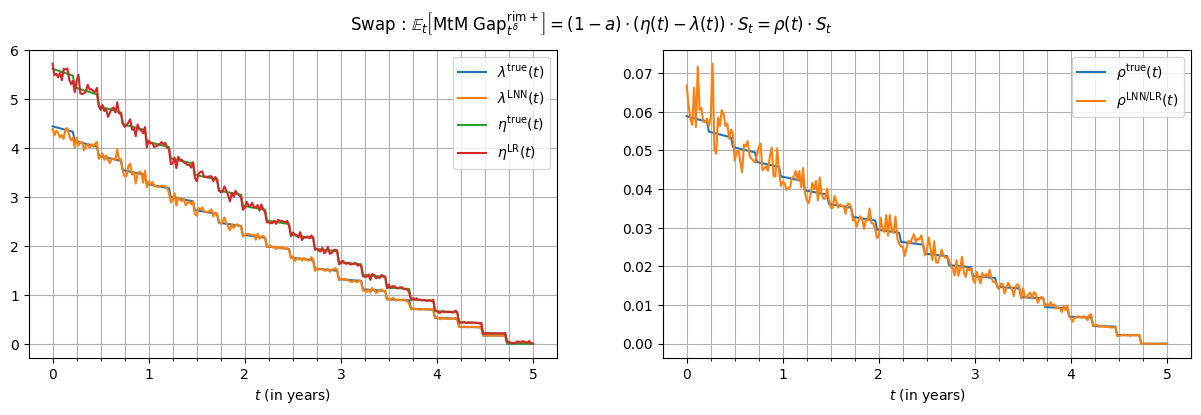

In [31]:
fig, axs = plt.subplots(figsize=(15, 4), ncols=2)
axs[0].plot(time_grid, lambda_vals, label='$\\lambda^{\\text{true}}(t)$')
axs[0].plot(time_grid, lambda_vals_lnn, label='$\\lambda^{\\text{LNN}}(t)$')
axs[0].plot(time_grid, eta_vals, label='$\\eta^{\\text{true}}(t)$')
axs[0].plot(time_grid, eta_vals_lr, label='$\\eta^{\\text{LR}}(t)$')
axs[0].set_xlabel('$t$ (in years)')
axs[0].set_xticks(swap_grid, minor=True)
axs[0].grid(which='both')
axs[0].legend()
print(f"MSE lambda LNN: {np.mean((lambda_vals - lambda_vals_lnn)**2):.4f}")
print(f"MSE eta LR: {np.mean((eta_vals - eta_vals_lr)**2):.4f}")
axs[1].plot(time_grid, rho_vals, label='$\\rho^{\\text{true}}(t)$')
axs[1].plot(time_grid, rho_vals_lin, label='$\\rho^{\\text{LNN/LR}}(t)$')
axs[1].set_xlabel('$t$ (in years)')
axs[1].set_xticks(swap_grid, minor=True)
axs[1].grid(which='both')
axs[1].legend()
print(f"MSE rho LNN/LR: {np.mean((rho_vals - rho_vals_lin)**2):.4f}")
plt.suptitle('Swap : $\\mathbb{E}_t\\left[\\text{MtM Gap}_{t^\\delta}^{\\text{rim} +}\\right] = (1-a) \\cdot \\left( \\eta(t) - \\lambda(t) \\right) \\cdot S_t = \\rho(t) \\cdot S_t$')
plt.show()

We see that the estimated coefficients are close to the true ones with a low MSE, but there is still some noise for the first pricing dates which comes from the same reasons as in [Question 1.2.](#question-1-2)

As in section 1, if we did not had access to the explicit formula of  $\mathbb{E}_t\left[\text{MtM Gap}^{\text{rim} +}_{t^\delta}\right]$ by the explicit formula of the functions $q_t$ and $s_t$, we could still validate our results with a twin Monte-Carlo method for quantile regression. Indeed, it can be shown that we have the following control bound for the value-at-risk estimate at time $t$ (see research paper mentionned in the subject):
$$
\left(\epsilon_t^\text{var}\right)^2 = \left\lVert \mathbb{P}\left[ \text{MtM Gap}_{t^\delta} \ge \hat q_t(S_t) \vert S_t \right] - (1-a) \right\rVert^2_{\mathbb{P}, 2}
= (1-a)^2 - (1-a) \left(\mathbb{P}\left[\text{MtM Gap}^{(1)}_{t^\delta}>\hat q_t(S_t)\right] + \mathbb{P}\left[\text{MtM Gap}^{(2)}_{t^\delta}>\hat q_t(S_t)\right] + \mathbb{P}\left[\text{MtM Gap}^{(1)}_{t^\delta} \wedge \text{MtM Gap}^{(2)}_{t^\delta} > \hat q_t(S_t)\right]\right),
$$
where $\text{MtM Gap}_{t^\delta}^{(1)}$ and $\text{MtM Gap}_{t^\delta}^{(2)}$ are defined as in the previous section. We can then approximate the error empirically.

In [32]:
varerr_swap_lnn_twin  = (1-a)**2 - a * np.mean(
    (mg_swap_paths>var_mg_swap_lnn_paths) + (mg_twin_swap_paths>var_mg_swap_lnn_paths) + (np.minimum(mg_swap_paths, mg_twin_swap_paths)>var_mg_swap_lnn_paths),
    axis=0
)

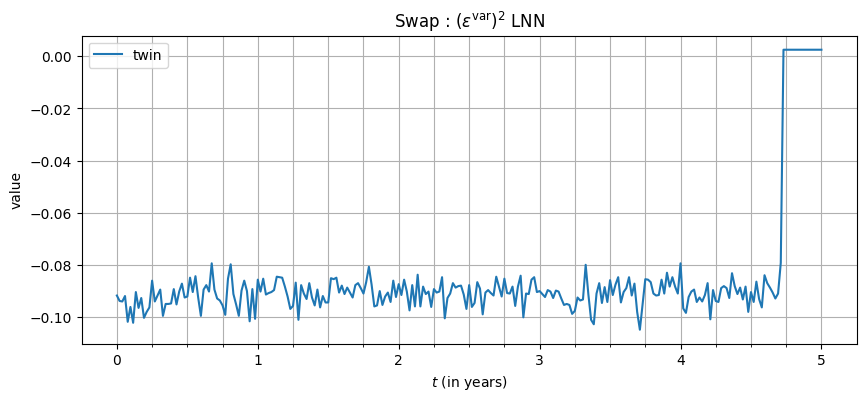

In [33]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(time_grid, varerr_swap_lnn_twin, label='twin')
ax.set_xlabel('$t$ (in years)')
ax.set_ylabel('value')
ax.set_xticks(swap_grid, minor=True)
ax.grid(which='both')
ax.legend()
ax.set_title('Swap : $\\left(\\epsilon^{\\text{var}}\\right)^2$ LNN')
plt.show()

We see that we still have the issue of [section 1](#section-1) with our Monte-Carlo twin method. A similar but more complex control bound can be derived for the expected shortfall estimate:
$$
\left\lVert \hat s_t(S_t) - s_t(S_t) \right\rVert _{\mathbb{P}, 2} \le \epsilon_t^\text{es} + \frac{2-a}{c (1-a)} \epsilon_t^\text{var},
$$
where $c$ is a constant and:
$$
\left(\epsilon_t^\text{es}\right)^2 = \left\lVert \hat s_t(S_t) - \hat q_t(S_t) \right\rVert^2_{\mathbb{P}, 2} + \frac{1}{(1-a)^2} \mathbb{E}\left[\left(\text{MtM Gap}^{(1)}_{t^\delta} - \hat q_t(S_t)\right)^+ \left(\text{MtM Gap}^{(2)}_{t^\delta} - \hat q_t(S_t)\right)^+\right] - \frac{2}{1-a} \mathbb{E}\left[\left(\hat s_t(S_t) - \hat q_t(S_t)\right) \left(\text{MtM Gap}^{(1)}_{t^\delta} - \hat q_t(S_t)\right)^+\right].
$$

In [34]:
eserr_swap_lnn_twin  = np.mean(
    (es_mg_swap_lr_paths - var_mg_swap_lnn_paths)**2 + 1/(1-a)*np.maximum(mg_swap_paths-var_mg_swap_lnn_paths, 0)*np.maximum(mg_twin_swap_paths-var_mg_swap_lnn_paths, 0)
    - 2/(1-a)*(es_mg_swap_lr_paths - var_mg_swap_lnn_paths)*np.maximum(mg_swap_paths - var_mg_swap_lnn_paths, 0),
    axis=0
)

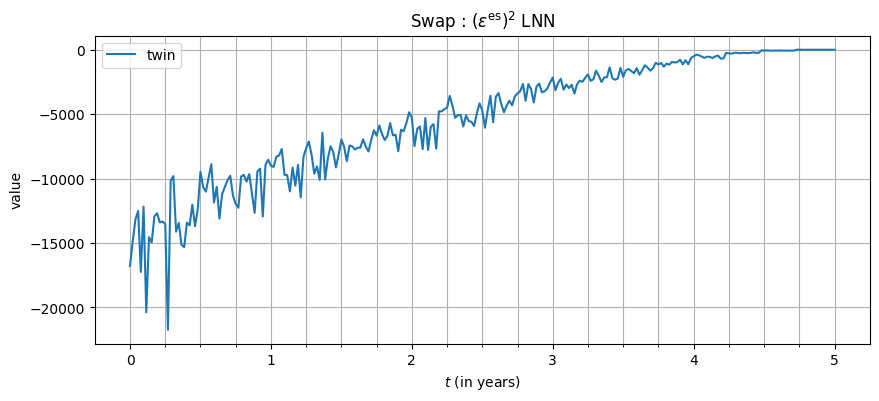

In [35]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(time_grid, eserr_swap_lnn_twin, label='twin')
ax.set_xlabel('$t$ (in years)')
ax.set_ylabel('value')
ax.set_xticks(swap_grid, minor=True)
ax.grid(which='both')
ax.legend()
ax.set_title('Swap : $\\left(\\epsilon^{\\text{es}}\\right)^2$ LNN')
plt.show()

Again, the result is not valid.

Finally, we can validate our estimation of $q_t$ and $s_t$ by comparing them with a nested Monte-Carlo simulation. Given a trajectory $(S_t)$, we approximate $\mathbb{V}\text{a}\mathbb{R}_t^a(\text{MtM Gap}_{t^\delta})$ by the empirical quantile and $\mathbb{ES}_t^a$ by an empirical mean of samples above empirical quantile, for $K$ i.i.d. samples of $\text{MtM Gap}_{t^\delta}$ knowing $S_t$, as for the twin Monte-Carlo method. Thus, we generate $K = \sqrt{M}$ new samples of $\text{MtM Gap}_{t^\delta}$ for each pricing date $(t, S_t)$.

In [36]:
def gen_var_es_mg_swap_nmc(S_paths):
    var = np.zeros_like(S_paths)
    es  = np.zeros_like(S_paths)
    for i in tqdm(range(N), desc='Processing nested Monte Carlo'):
        new_points  = S_paths[:, i]*np.exp((kappa - 0.5*sigma**2)*delta + sigma*np.sqrt(delta)*np.random.normal(0, 1, size=(M_nmc, len(S_paths))))
        new_mtm     = nom*f_vals[i]*(np.exp(-kappa*time_grid[i+1])*new_points-np.exp(-kappa*time_grid[i])*S_paths[:, i])
        var[:, i]   = np.quantile(new_mtm, a, axis=0)
        es[:, i]    = np.mean(new_mtm, where=new_mtm>=var[:, i], axis=0)
    return var, es

var_mg_swap_nmc_paths, es_mg_swap_nmc_paths = gen_var_es_mg_swap_nmc(S_paths)
econd_mgprim_swap_nmc_paths                 = (1-a) * (es_mg_swap_nmc_paths - var_mg_swap_nmc_paths)

Processing nested Monte Carlo: 100%|██████████| 260/260 [00:05<00:00, 46.20it/s]


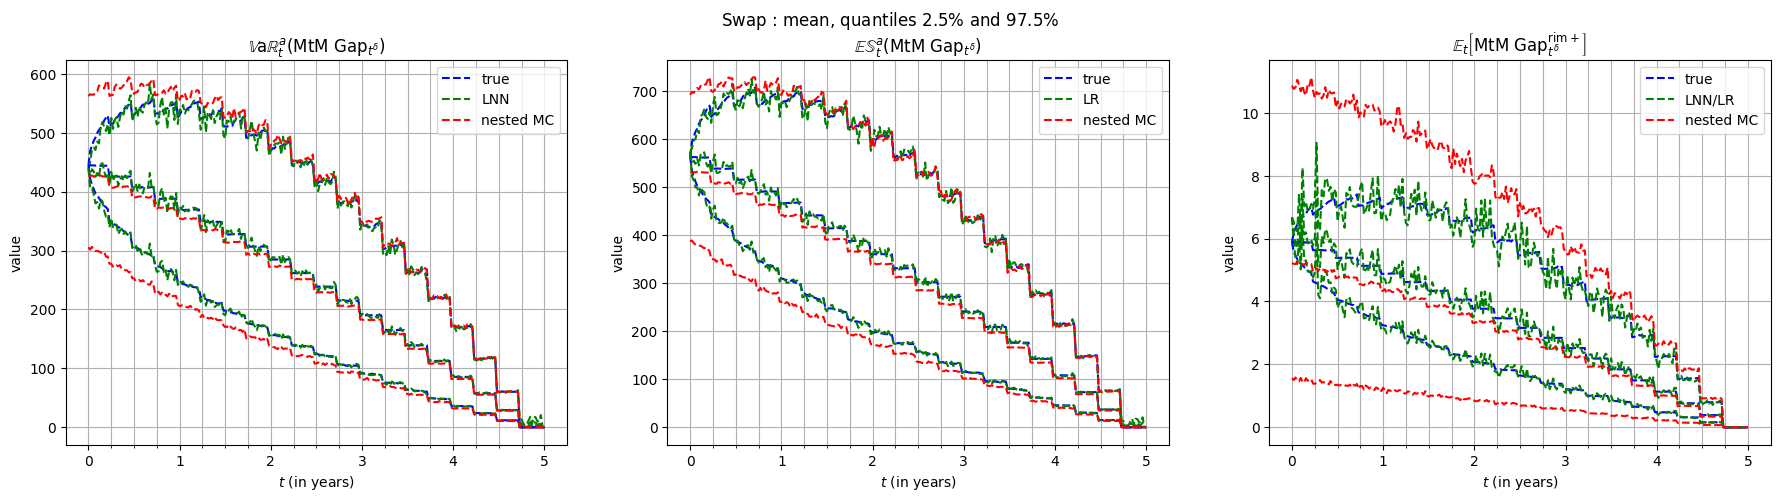

In [37]:
fig, axs = plt.subplots(figsize=(22, 5), ncols=3)

def plot_fig(i, res1, res2, res3, lab1, lab2, lab3):
    axs[i].plot(time_grid, np.quantile(res1, 0.975, axis=0), label=lab1, linestyle='--', color='blue')
    axs[i].plot(time_grid, np.quantile(res2, 0.975, axis=0), label=lab2, linestyle='--', color='green')
    axs[i].plot(time_grid, np.quantile(res3, 0.975, axis=0), label=lab3, linestyle='--', color='red')

    axs[i].plot(time_grid, np.quantile(res1, 0.025, axis=0), linestyle='--', color='blue')
    axs[i].plot(time_grid, np.quantile(res2, 0.025, axis=0), linestyle='--', color='green')
    axs[i].plot(time_grid, np.quantile(res3, 0.025, axis=0), linestyle='--', color='red')

    axs[i].plot(time_grid, np.mean(res1, axis=0), linestyle='--', color='blue')
    axs[i].plot(time_grid, np.mean(res2, axis=0), linestyle='--', color='green')
    axs[i].plot(time_grid, np.mean(res3, axis=0), linestyle='--', color='red')
    axs[i].set_xlabel('$t$ (in years)')
    axs[i].set_ylabel('value')
    axs[i].set_xticks(swap_grid, minor=True)
    axs[i].grid(which='both')
    axs[i].legend()

plot_fig(0, var_mg_swap_paths, var_mg_swap_lnn_paths, var_mg_swap_nmc_paths, 'true', 'LNN', 'nested MC')
axs[0].set_title('$\\mathbb{V}\\text{a}\\mathbb{R}_t^a(\\text{MtM Gap}_{t^\\delta})$')
plot_fig(1, es_mg_swap_paths, es_mg_swap_lr_paths, es_mg_swap_nmc_paths, 'true', 'LR', 'nested MC')
axs[1].set_title('$\\mathbb{ES}_t^a(\\text{MtM Gap}_{t^\\delta})$')
plot_fig(2, econd_mgprim_swap_paths, econd_mgprim_swap_lin_paths, econd_mgprim_swap_nmc_paths, 'true', 'LNN/LR', 'nested MC')
axs[2].set_title('$\\mathbb{E}_t\\left[\\text{MtM Gap}_{t^\\delta}^{\\text{rim} +}\\right]$')
plt.suptitle('Swap : mean, quantiles $2.5\\%$ and $97.5\\%$')
plt.show()

We see that the estimations of $q_t$ and $s_t$ are close to the ground truth. We observe that the estimations for $\mathbb{E}_t\left[\text{MtM Gap}^{\text{rim} +}_{t^\delta}\right]$ are highly noisy. It is due to the fact that noise in the estimation of $q_t$ is amplified in the estimation of $s_t$ (as we compute $s_t$ using the estimation of $q_t$), and we substract $q_t$ from $s_t$ to get $\rho_t$ which yields even higher noise. Moreover, the nested Monte-Carlo method seems to produce more variance, as seen in section 1, but has also a mean always below the ground truth mean for $\mathbb{V}\text{a}\mathbb{R}_t^a(\text{MtM Gap}_{t^\delta})$ and $\mathbb{ES}_t^a(\text{MtM Gap}_{t^\delta})$. It can be due to the limited number of samples in the nested Monte-Carlo and that we are estimating some quantities in the distribution tail.

#### <span id="question-2-4" style="color:#00B8DE"> Question 2.4. </span>

Now, the CVA can be computed using our previous estimators $\hat q_t(S_t)$ of $\mathbb{V}\text{a}\mathbb{R}_t^a(\text{MtM Gap}_{t^\delta})$ and $\hat s_t(S_t)$ of $\mathbb{ES}_t^a(\text{MtM Gap}_{t^\delta})$, approximating the integral numerically, and taking an empirical mean over our $M$ iid samples $\hat q_t\left(S_t^{(m)}\right)$ and $\hat s_t\left(S_t^{(m)}\right)$.

Notice that we can validate our results using empirical mean for the outer expecation and the formula or nested Monte-Carlo simulation for the inner conditional expectation, but also using the formula of $\text{CVA}^\text{rim}_0$ for a swap, proven in [Question 2.1.](#question-2-1)

In [38]:
c_vals      = rho_vals[:-1]/(nom * np.exp(-kappa*time_grid[:-1]))
cvarim_swap = nom*S0*np.trapezoid(c_vals * np.exp(-gamma*time_grid[:-1]) * gamma, dx=delta)

In [39]:
cvarim_swap_mc  = calc_cva(econd_mgprim_swap_paths)
cvarim_swap_lin = calc_cva(econd_mgprim_swap_lin_paths)
cvarim_swap_nmc = calc_cva(econd_mgprim_swap_nmc_paths)

print(f"CVA swap formula: {cvarim_swap:.4f}")
print(f"CVA swap using MC for outer expectation and formula for conditional expectation: {cvarim_swap_mc:.4f}")
print(f"CVA swap using MC for outer expectation and LNN/LR for conditional expectation: {cvarim_swap_lin:.4f}")
print(f"CVA swap using MC for outer expectation and nested MC for conditional expectation: {cvarim_swap_nmc:.4f}")

CVA swap formula: 1.3318
CVA swap using MC for outer expectation and formula for conditional expectation: 1.3363
CVA swap using MC for outer expectation and LNN/LR for conditional expectation: 1.3492
CVA swap using MC for outer expectation and nested MC for conditional expectation: 1.1849


All the estimated CVA have the same magnitude as the true one, with the CVA estimated using nested Monte-Carlo being too low, mainly because of the small number of samples. We also remark that the CVA with RIM is almost 20 times lower than the CVA without RIM (see question 1.3.), which is a good result as we expect the RIM to erode the CVA (less gap risk).

### <span style="color:#008000"> Interest Rate Call Option

#### <span id="question-2-5" style="color:#00B8DE"> Question 2.5. </span>

In the case of the call, as in [question 1.4.](#question-1-4), we do not expect to have linear functions $q_t(S_t) =  \mathbb{V}\text{a}\mathbb{R}_t^a(\text{MtM Gap}_{t^\delta})$ nor $s_t(S_t) = \mathbb{ES}_t^a(\text{MtM Gap}_{t^\delta})$ anymore. Thus, we will approximate both these functions by regressing them considering first non-linear neural networks functions, and then polynomial functions. Our results will be validated with twin Monte-Carlo method and nested Monte-Carlo simulation, as in the previous questions (but loosing analytical formulas).

We train two non-linear neural networks (taking the same hyperparameters as in [question 1.4.](#question-1-4)) at each pricing date $t$ using $\left(S_t^{(m)}, \text{MtM Gap}_{t^\delta}^{+ (m)}\right)_m$ and calculate the paths $\left(\hat q_t^{\text{NLNN}}(S_t)\right)$ and $\left(\hat s_t^{\text{NLNN}}(S_t)\right)$ for our different trajectories of $(S_t)$.

In [40]:
var_mg_call_nlnn_paths      = np.zeros_like(S_paths)
nepochs                     = 300
train_losses_var_call_nlnn  = np.zeros((N+1, nepochs))
for i in tqdm(range(N), desc='Training nonlinear neural network'):
    x       = torch.tensor(S_paths[:, i].reshape(-1, 1), dtype=torch.float32)
    x       = (x - x.mean())/x.std() if x.std() > 0 else x
    y       = torch.tensor(mg_call_paths[:, i].reshape(-1, 1), dtype=torch.float32)
    model   = NonLinearNN(input_dim=1)
    crit    = lambda y_hat, y: torch.mean(pinball_loss(y_hat, y, a))
    optim   = torch.optim.Adam(model.parameters(), lr=5*10**(-2))
    for epoch in range(nepochs):
        model.train()
        optim.zero_grad()
        loss = crit(model(x), y)
        loss.backward()
        optim.step()
        train_losses_var_call_nlnn[i, epoch] = loss.item()
    var_mg_call_nlnn_paths[:, i] = model(x).detach().numpy().reshape(-1)

Training nonlinear neural network: 100%|██████████| 260/260 [02:10<00:00,  1.99it/s]


In [41]:
es_mg_call_nlnn_paths       = np.zeros_like(S_paths)
nepochs                     = 300
train_losses_es_call_nlnn   = np.zeros((N+1, nepochs))
for i in tqdm(range(N), desc='Training nonlinear neural network'):
    x       = torch.tensor(S_paths[:, i].reshape(-1, 1), dtype=torch.float32)
    x       = (x - x.mean())/x.std() if x.std() > 0 else x
    y       = torch.tensor(pinball_loss_np(var_mg_call_nlnn_paths[:, i], mg_call_paths[:, i], a).reshape(-1, 1), dtype=torch.float32)
    model   = NonLinearNN(input_dim=1)
    crit    = nn.MSELoss()
    optim   = torch.optim.Adam(model.parameters(), lr=5*10**(-2))
    for epoch in range(nepochs):
        model.train()
        optim.zero_grad()
        loss = crit(model(x), y)
        loss.backward()
        optim.step()
        train_losses_es_call_nlnn[i, epoch] = loss.item()
    es_mg_call_nlnn_paths[:, i] = model(x).detach().numpy().reshape(-1)

Training nonlinear neural network: 100%|██████████| 260/260 [01:55<00:00,  2.25it/s]


In [42]:
econd_mgprim_call_nlnn_paths = (1-a) * (es_mg_call_nlnn_paths - var_mg_call_nlnn_paths)

In order to use polynomial functions as a family of regressors for $q_t$, we can't simply use a linear regression model with polynomial features as in [question 1.4.](#question-1-4) because the loss is not the mean square error. Thus, we will use a (one layer) linear neural network with polynomial features and loss function being the pinball loss.

In [43]:
var_mg_call_pr_paths        = np.zeros_like(S_paths)
nepochs                     = 300
train_losses_var_call_pr    = np.zeros((N+1, nepochs))
for i in tqdm(range(N), desc='Training linear neural network'):
    poly    = PolynomialFeatures(degree=3, include_bias=True)
    x       = poly.fit_transform(S_paths[:, i].reshape(-1, 1))
    x       = torch.tensor(x, dtype=torch.float32)
    y       = torch.tensor(mg_call_paths[:, i].reshape(-1, 1), dtype=torch.float32)
    model   = LinearNN(input_dim=4)
    crit    = lambda y_hat, y: torch.mean(pinball_loss(y_hat, y, a))
    optim   = torch.optim.Adam(model.parameters(), lr=5*10**(-3))

    for epoch in range(nepochs):
        model.train()
        optim.zero_grad()
        loss = crit(model(x), y)
        loss.backward()
        optim.step()
        train_losses_var_call_pr[i, epoch] = loss.item()
        
    var_mg_call_pr_paths[:, i] = model(x).detach().numpy().reshape(-1)

Training linear neural network: 100%|██████████| 260/260 [00:51<00:00,  5.05it/s]


In [44]:
es_mg_call_pr_paths = np.zeros_like(S_paths)
for i in range(N):
    model   = LinearRegression(fit_intercept=False)
    poly    = PolynomialFeatures(degree=3, include_bias=True)
    S_poly  = poly.fit_transform(S_paths[:, i].reshape(-1, 1))
    model.fit(S_poly, pinball_loss_np(var_mg_call_pr_paths[:, i], mg_call_paths[:, i], a))
    es_mg_call_pr_paths[:, i] = model.predict(S_poly)

In [45]:
econd_mgprim_call_pr_paths = (1-a) * (es_mg_call_pr_paths - var_mg_call_pr_paths)

As in question 3, Let us validate our result for the value-at-risk with a twin Monte-Carlo method.

Let us validate our result for the value-at-risk and expected shortfall with twin Monte-Carlo methodx as in [Question 2.3.](#question-2-3).

In [46]:
varerr_call_nlnn_twin  = (1-a)**2 - (1-a) * np.mean(
    (mg_call_paths>var_mg_call_nlnn_paths) + (mg_twin_call_paths>var_mg_call_nlnn_paths) + (np.minimum(mg_call_paths, mg_twin_call_paths)>var_mg_call_nlnn_paths),
    axis=0
)

varerr_call_pr_twin   = (1-a)**2 - (1-a) * np.mean(
    (mg_call_paths>var_mg_call_pr_paths) + (mg_twin_call_paths>var_mg_call_pr_paths) + (np.minimum(mg_call_paths, mg_twin_call_paths)>var_mg_call_pr_paths),
    axis=0
)

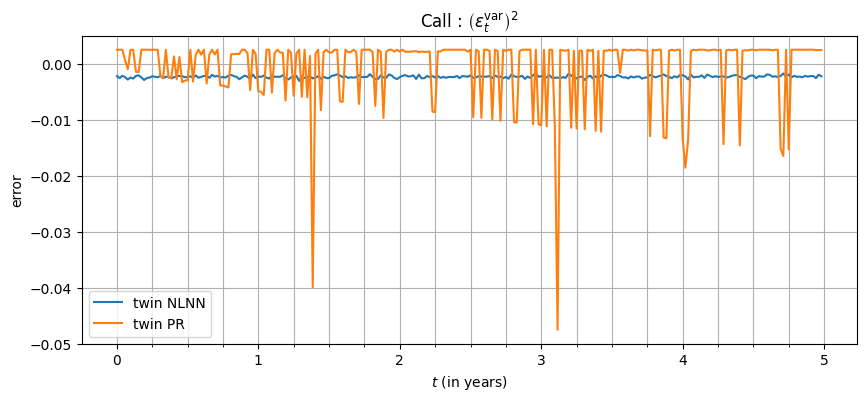

In [47]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(time_grid[:-1], varerr_call_nlnn_twin[:-1], label='twin NLNN')
ax.plot(time_grid[:-1], varerr_call_pr_twin[:-1], label='twin PR')
ax.set_xlabel('$t$ (in years)')
ax.set_ylabel('error')
ax.set_xticks(swap_grid, minor=True)
ax.grid(which='both')
ax.set_title('Call : $\\left(\\epsilon_t^\\text{var}\\right)^2$')
ax.legend()
plt.show()

In [48]:
eserr_call_nlnn_twin  = np.mean(
    (es_mg_call_nlnn_paths - var_mg_call_nlnn_paths)**2 + 1/(1-a)*np.maximum(mg_call_paths-var_mg_call_nlnn_paths, 0)*np.maximum(mg_twin_call_paths-var_mg_call_nlnn_paths, 0)
    - 2/(1-a)*(es_mg_call_nlnn_paths - var_mg_call_nlnn_paths)*np.maximum(mg_call_paths - var_mg_call_nlnn_paths, 0),
    axis=0
)

eserr_call_pr_twin  = np.mean(
    (es_mg_call_pr_paths - var_mg_call_pr_paths)**2 + 1/(1-a)*np.maximum(mg_call_paths-var_mg_call_pr_paths, 0)*np.maximum(mg_twin_call_paths-var_mg_call_pr_paths, 0)
    - 2/(1-a)*(es_mg_call_pr_paths - var_mg_call_pr_paths)*np.maximum(mg_call_paths - var_mg_call_pr_paths, 0),
    axis=0
)

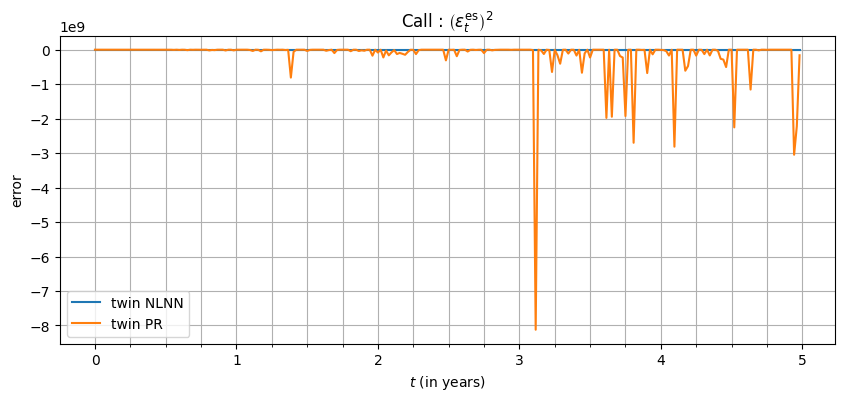

In [49]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(time_grid[:-1], eserr_call_nlnn_twin[:-1], label='twin NLNN')
ax.plot(time_grid[:-1], eserr_call_pr_twin[:-1], label='twin PR')
ax.set_xlabel('$t$ (in years)')
ax.set_ylabel('error')
ax.set_xticks(swap_grid, minor=True)
ax.grid(which='both')
ax.set_title('Call : $\\left(\\epsilon_t^\\text{es}\\right)^2$')
ax.legend()
plt.show()

Again, our twin Monte Carlo are still not valid.

Finally, we can validate our estimations of $q_t$ and $s_t$ by comparing them with a nested Monte-Carlo simulation.

In [50]:
def gen_var_es_mg_call_nmc(S_paths):
    var = np.zeros_like(S_paths)
    es  = np.zeros_like(S_paths)
    for i in tqdm(range(N), desc='Processing nested Monte Carlo'):
        d1          = (np.log(S_paths[:, i]/S0) + (kappa + 0.5*sigma**2)*(T-time_grid[i])) / (sigma*np.sqrt(T-time_grid[i]))
        d2          = d1 - sigma*np.sqrt(T-time_grid[i])
        mtm         = np.exp(-r*(T-time_grid[i]))*(S_paths[:, i]*np.exp(kappa*(T-time_grid[i]))*norm.cdf(d1) - S0*norm.cdf(d2))
        new_points  = S_paths[:, i]*np.exp((kappa - 0.5*sigma**2)*delta + sigma*np.sqrt(delta)*np.random.normal(0, 1, size=(M_nmc, len(S_paths))))
        if i == N-1:
            new_mtms    = np.maximum(new_points - S0, 0)
        else:
            d1          = (np.log(new_points/S0) + (kappa + 0.5*sigma**2)*(T-time_grid[i+1])) / (sigma*np.sqrt(T-time_grid[i+1]))
            d2          = d1 - sigma*np.sqrt(T-time_grid[i+1])
            new_mtms    = np.exp(-r*(T-time_grid[i+1]))*(new_points*np.exp(kappa*(T-time_grid[i+1]))*norm.cdf(d1) - S0*norm.cdf(d2))
        new_gap     = beta(time_grid[i+1])*new_mtms - beta(time_grid[i])*mtm
        var[:, i]   = np.quantile(new_gap, a, axis=0)
        es[:, i]    = np.mean(new_gap, where=new_gap>=var[:, i], axis=0)
    return var, es

var_mg_call_nmc_paths, es_mg_call_nmc_paths = gen_var_es_mg_call_nmc(S_paths)
econd_mgprim_call_nmc_paths                 = (1-a) * (es_mg_call_nmc_paths - var_mg_call_nmc_paths)

Processing nested Monte Carlo: 100%|██████████| 260/260 [00:17<00:00, 15.24it/s]


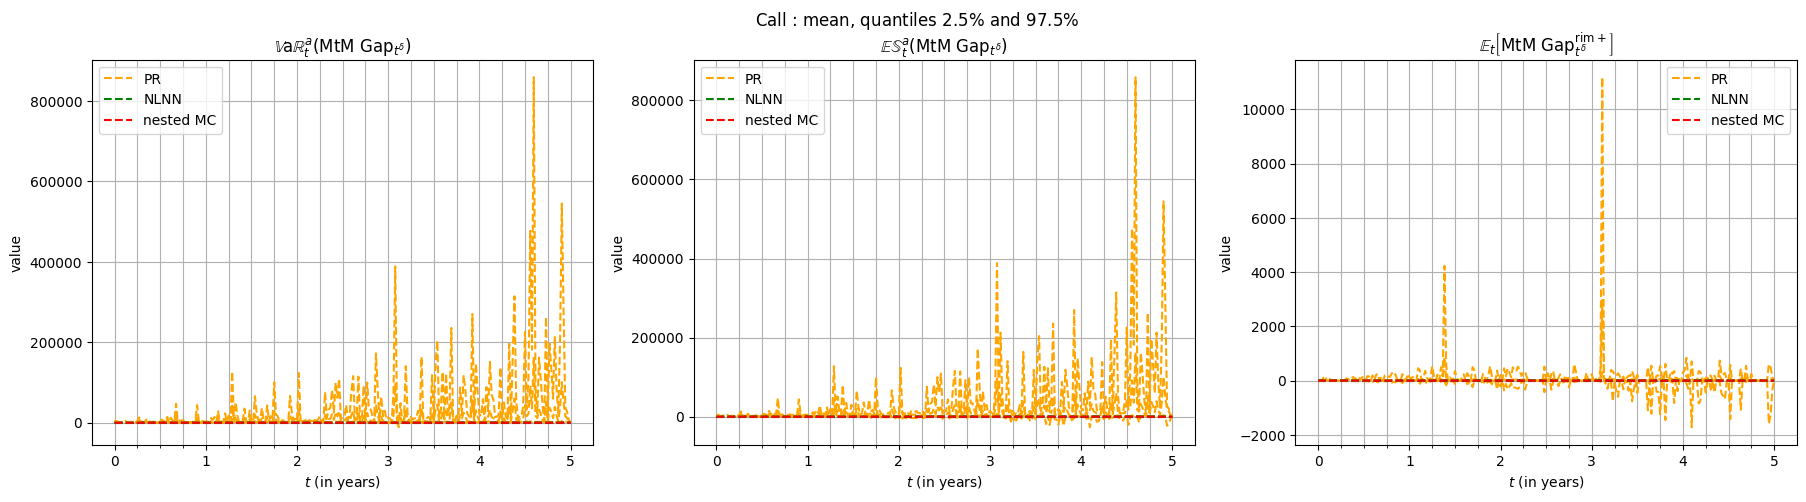

In [51]:
fig, axs = plt.subplots(figsize=(22, 5), ncols=3)

def plot_fig(i, res1, res2, res3, lab1, lab2, lab3):
    axs[i].plot(time_grid, np.quantile(res1, 0.975, axis=0), label=lab1, linestyle='--', color='orange')
    axs[i].plot(time_grid, np.quantile(res2, 0.975, axis=0), label=lab2, linestyle='--', color='green')
    axs[i].plot(time_grid, np.quantile(res3, 0.975, axis=0), label=lab3, linestyle='--', color='red')

    axs[i].plot(time_grid, np.quantile(res1, 0.025, axis=0), linestyle='--', color='orange')
    axs[i].plot(time_grid, np.quantile(res2, 0.025, axis=0), linestyle='--', color='green')
    axs[i].plot(time_grid, np.quantile(res3, 0.025, axis=0), linestyle='--', color='red')

    axs[i].plot(time_grid, np.mean(res1, axis=0), linestyle='--', color='orange')
    axs[i].plot(time_grid, np.mean(res2, axis=0), linestyle='--', color='green')
    axs[i].plot(time_grid, np.mean(res3, axis=0), linestyle='--', color='red')
    axs[i].set_xlabel('$t$ (in years)')
    axs[i].set_ylabel('value')
    axs[i].set_xticks(swap_grid, minor=True)
    axs[i].grid(which='both')
    axs[i].legend()

plot_fig(0, var_mg_call_pr_paths, var_mg_call_nlnn_paths, var_mg_call_nmc_paths, 'PR', 'NLNN', 'nested MC')
axs[0].set_title('$\\mathbb{V}\\text{a}\\mathbb{R}_t^a(\\text{MtM Gap}_{t^\\delta})$')
plot_fig(1, es_mg_call_pr_paths, es_mg_call_nlnn_paths, es_mg_call_nmc_paths, 'PR', 'NLNN', 'nested MC')
axs[1].set_title('$\\mathbb{ES}_t^a(\\text{MtM Gap}_{t^\\delta})$')
plot_fig(2, econd_mgprim_call_pr_paths, econd_mgprim_call_nlnn_paths, econd_mgprim_call_nmc_paths, 'PR', 'NLNN', 'nested MC')
axs[2].set_title('$\\mathbb{E}_t\\left[\\text{MtM Gap}_{t^\\delta}^{\\text{rim} +}\\right]$')
plt.suptitle('Call : mean, quantiles $2.5\\%$ and $97.5\\%$')
plt.show()

We see that the estimations of $q_t$ and $s_t$ are close to the nested MC, but much more noisy than for the swap. It is due to the fact that the function to learn here is more challenging since it is not linear anymore. This high variance even produces negative values for $\mathbb{E_t}\left[\text{MtM Gap}^{\text{rim} +}_{t^\delta}\right]$ which is not valid in reality. A fine-tuning of the hyperparameters as well as more samples could yield better results.

As in Question 2.4., the CVA can be computed using our previous estimators $\hat q_t(S_t)$ and $\hat s_t(S_t)$, approximating the integral numerically, and taking an empirical mean over our $M$ iid samples $\hat u_t\left(S_t^{(m)}\right)$.

In [52]:
cvarim_call_nlnn    = calc_cva(econd_mgprim_call_nlnn_paths)
cvarim_call_pr      = calc_cva(econd_mgprim_call_pr_paths)
cvarim_call_nmc     = calc_cva(econd_mgprim_call_nmc_paths)

print(f"CVA call using MC for outer expectation and NLNN for conditional expectation: {cvarim_call_nlnn:.4f}")
print(f"CVA call using MC for outer expectation and PR for conditional expectation: {cvarim_call_pr:.4f}")
print(f"CVA call using MC for outer expectation and nested MC for conditional expectation: {cvarim_call_nmc:.4f}")

CVA call using MC for outer expectation and NLNN for conditional expectation: 0.0381
CVA call using MC for outer expectation and PR for conditional expectation: 12.6461
CVA call using MC for outer expectation and nested MC for conditional expectation: 0.0337


It is difficult to draw conclusions from these results as we do not have access to the ground truth nor to a companion Monte-Carlo method. Indeed we would need paths of ${\text{MtM Gap}}^{\text{rim} +}_{t^\delta}$ to calculate $\mathbb{E}\left[\text{MtM Gap}^{\text{rim} +}_{t^\delta}\right]$, which cannot be obtained as they feature $\mathbb{V}\text{a}\mathbb{R}_t^a\left(\text{MtM Gap}_{t^\delta}\right)$. Thus, learning the conditional expectation is necessary here, even for computing only $\text{CVA}_0$ with RIM. Nonetheless, we see that the results are of same magnitude and about $20$ times lower than the CVA without RIM, which echoes perfectly to the results for the swap case.

#### <span id="question-2-6" style="color:#00B8DE"> Question 2.6. </span>

In this question, we want to calculate the CVA with RIM simultaneously for different levels of $a$. As opposed to the single $a$ approach where we should do again the training procedure for each $a$ considered, we introduce here a multi $a$ approach. A natural way to do so is to randomize $a$ and express it as a feature of the neural network for estimating value-at-risk. We can then still calculate the expected shortfall by linear or polynomial regression for each value of $a$ of interest, as it is not time consuming. It is referred as multi-$\alpha(II)$ approach in the research paper mentionned.

However, a point of attention is the problem of crossing quantile curves, i.e. the violation of the monotonicity with respect to $a$. Indeed, the value-at-risk should be an increasing function of $a$. There exist many ways to handle this issue, such as penalizing the loss function by the negative part of the derivative of the neural network function with respect to $a$, scaled by a factor $\lambda$. We will refer to this approach as multi-$\alpha(I)$. Notice that the multi-$\alpha(II)$ described above is the particular case of multi-$\alpha(II)$ where $\lambda = 0$. Now, how to choose the value of $\lambda$ ? A good way to do so is to use a validation set and choose $\lambda$ accordingly. We can also use a fixed value of $\lambda$, and in this case, we decided to take $\lambda = 0.1$.

Moreover, we randomize $a$ with a uniform distribution: $a \sim \mathcal{U}\left([0.85, 0.99]\right)$.

### <span style="color:#008000"> Interest Rate Swap

We will test these multi-$\alpha$ learning approaches only for the swap, as we have the closed form to validate our results. Similar computations can be done for the call option. Notice that we can't use anymore a one layer linear neural network since we have to take into account the feature $a$ in the neural network function. We will evaluate the results for $a = 90\%, 95\%, 97.5\%$.

In [187]:
a_samples_np    = 0.85 + (0.99-0.85)*np.random.rand(M)
a_samples       = torch.tensor(a_samples_np, dtype=torch.float32).reshape(-1, 1)
a_vals          = np.array([0.90, 0.95, 0.975])

Let's first train the non-linear neural network with penalization and without. An important question is how to compute the loss of the neural betwork with respect to $a$ ? Although it can be done explicitly as our achitecture is relatively simple, we have decided (to keep things simple) to use automatic differentiation. It is a technique that allows to compute the gradient of a function with respect to its inputs using the chain rule, and is implemented in Pytorch.

We try to speed up convergence by initializing the weights for the next pricing date with the weights of the previous pricing date, as in [Question 1.4.](#question-1-4)

In [195]:
nepochs  = 200
def var_train_multia(lambda_):
    var_mg_swap_nlnn_mul_paths      = np.zeros((M, N+1, len(a_vals)))
    train_losses_var_swap_nlnn_mul  = np.zeros((N+1, nepochs))
    
    for i in tqdm(range(N), desc='Training nonlinear neural network'):
        model   = NonLinearNN(input_dim=2)
        x       = torch.tensor(np.column_stack((S_paths[:, i], a_samples_np)), dtype=torch.float32, requires_grad=True)
        y       = torch.tensor(mg_swap_paths[:, i].reshape(-1, 1), dtype=torch.float32)
        crit    = lambda y_hat, y: torch.mean(pinball_loss(y_hat, y, a_samples))
        optim   = torch.optim.Adam(model.parameters(), lr=5*10**(-2))
        for epoch in range(nepochs):
            model.train()
            optim.zero_grad()
            y_hat = model(x)
            if lambda_ > 0: # multi-a (I) : non-crossing quantile regularization
                dy_hat = torch.autograd.grad(outputs=y_hat, inputs=x, grad_outputs=torch.ones_like(y_hat), create_graph=True)[0]
                monotonicity_penalty = lambda_*torch.relu(dy_hat[:, 1]).mean()
                loss = crit(y_hat, y) + monotonicity_penalty
            else: # multi-a (II) : no penalization
                loss = crit(model(x), y)
            loss.backward()
            optim.step()
            train_losses_var_swap_nlnn_mul[i, epoch] = loss.item()
        for j, a_val in enumerate(a_vals):
            var_mg_swap_nlnn_mul_paths[:, i, j] = model(torch.tensor(np.column_stack((S_paths[:, i], np.full(M, a_val))), dtype=torch.float32)).detach().numpy().reshape(-1)
    return train_losses_var_swap_nlnn_mul, var_mg_swap_nlnn_mul_paths

In [196]:
train_losses_var_swap_nlnn_mul2, var_mg_swap_nlnn_mul2_paths = var_train_multia(0)
lambda_ = 0.1
train_losses_var_swap_nlnn_mul1, var_mg_swap_nlnn_mul1_paths = var_train_multia(lambda_)

Training nonlinear neural network: 100%|██████████| 260/260 [02:26<00:00,  1.77it/s]


Now, for each value of $a$ we are interested in, we compute the expected shortfall using a linear regression model, as in [Question 2.2.](#question-2-2) This is done $a$ by $a$ and not in a multi-learning fashion.

In [197]:
es_mg_swap_lr_mul2_paths = np.zeros((M, N+1, len(a_vals)))
for j, a_val in enumerate(a_vals):
    for i in range(N+1):
        model = LinearRegression(fit_intercept=False)
        model.fit(S_paths[:, i].reshape(-1, 1), pinball_loss_np(var_mg_swap_nlnn_mul2_paths[:, i, j], mg_swap_paths[:, i], a_val))
        es_mg_swap_lr_mul2_paths[:, i, j] = model.predict(S_paths[:, i].reshape(-1, 1))


es_mg_swap_lr_mul1_paths = np.zeros((M, N+1, len(a_vals)))
for j, a_val in enumerate(a_vals):
    for i in range(N+1):
        model = LinearRegression(fit_intercept=False)
        model.fit(S_paths[:, i].reshape(-1, 1), pinball_loss_np(var_mg_swap_nlnn_mul1_paths[:, i, j], mg_swap_paths[:, i], a_val))
        es_mg_swap_lr_mul1_paths[:, i, j] = model.predict(S_paths[:, i].reshape(-1, 1))

Finally, we can calculate for each multi-$\alpha$ method our estimations of $\mathbb{E}_t\left[\text{MtM Gap}^{\text{rim} +}_{t^\delta}\right]$ for each $a$.

In [198]:
econd_MtMgaprim_swap_nlin_mul2_paths  = (1-a_vals) * (es_mg_swap_lr_mul2_paths - var_mg_swap_nlnn_mul2_paths)
econd_MtMgaprim_swap_nlin_mul1_paths  = (1-a_vals) * (es_mg_swap_lr_mul1_paths - var_mg_swap_nlnn_mul1_paths)

How to validate our results ? We can compute and compare the true paths of $\left(\mathbb{E}_t\left[\text{MtM Gap}^{\text{rim} +}_{t^\delta}\right]\right)$ for our trajectories $(S_t)$ for each $a$ since we have the analytical formula.

In [199]:
var_mg_swap_mul_paths       = np.zeros((M, N+1, len(a_vals)))
es_mg_swap_mul_paths        = np.zeros((M, N+1, len(a_vals)))
econd_mgprim_swap_mul_paths = np.zeros((M, N+1, len(a_vals)))
for j, a_val in enumerate(a_vals):
    res                                     = gen_var_mg_swap(S_paths, a_val)
    var_mg_swap_mul_paths[:, :, j]          = res[1]
    res                                     = gen_es_mg_swap(S_paths, a_val)
    es_mg_swap_mul_paths[:, :, j]           = res[1]
    econd_mgprim_swap_mul_paths[:, :, j]    = (1-a_val) * (es_mg_swap_mul_paths[:, :, j] - var_mg_swap_mul_paths[:, :, j])

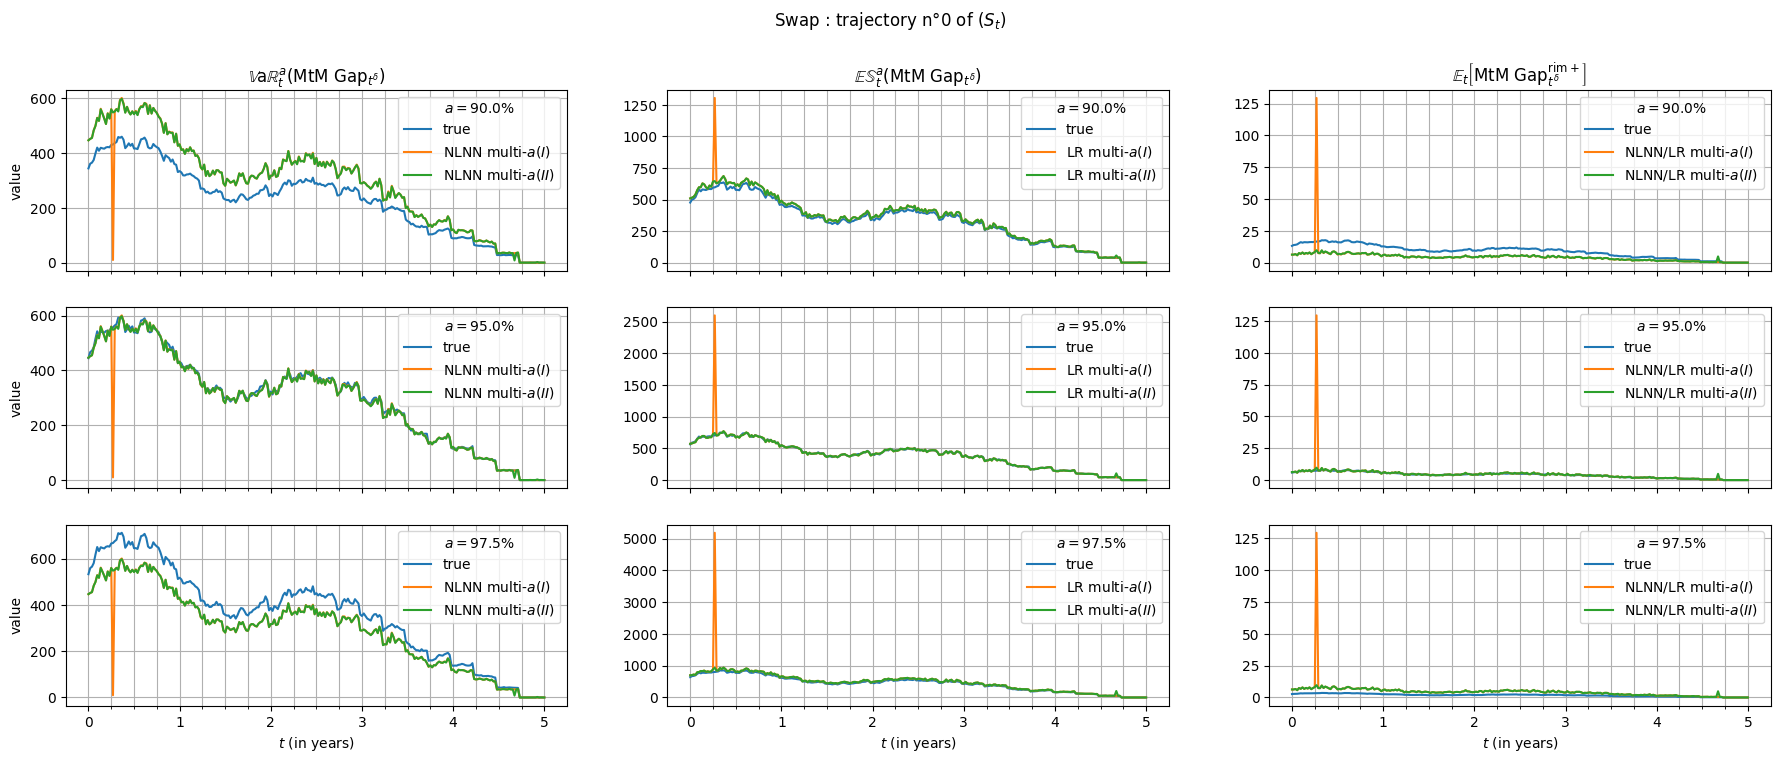

In [200]:
fig, axs = plt.subplots(figsize=(22, 8), ncols=3, nrows=len(a_vals), sharex=True)

axs[0, 0].set_title('$\\mathbb{V}\\text{a}\\mathbb{R}_t^a(\\text{MtM Gap}_{t^\\delta})$')
axs[0, 1].set_title('$\\mathbb{ES}_t^a(\\text{MtM Gap}_{t^\\delta})$')
axs[0, 2].set_title('$\\mathbb{E}_t\\left[\\text{MtM Gap}_{t^\\delta}^{\\text{rim} +}\\right]$')
axs[len(a_vals)-1, 0].set_xlabel('$t$ (in years)')
axs[len(a_vals)-1, 1].set_xlabel('$t$ (in years)')
axs[len(a_vals)-1, 2].set_xlabel('$t$ (in years)')

for j, a_val in enumerate(a_vals):
    
    axs[j, 0].plot(time_grid, var_mg_swap_mul_paths[0, :, j], label=f'true')
    axs[j, 0].plot(time_grid, var_mg_swap_nlnn_mul1_paths[0, :, j], label=f'NLNN multi-$a(I)$')
    axs[j, 0].plot(time_grid, var_mg_swap_nlnn_mul2_paths[0, :, j], label=f'NLNN multi-$a(II)$')
    axs[j, 0].set_ylabel(f'value')
    axs[j, 0].set_xticks(swap_grid, minor=True)
    axs[j, 0].grid(which='both')
    axs[j, 0].legend(title=f'$a = ${a_val:.1%}')
    
    axs[j, 1].plot(time_grid, es_mg_swap_mul_paths[0, :, j], label=f'true')
    axs[j, 1].plot(time_grid, es_mg_swap_lr_mul1_paths[0, :, j], label=f'LR multi-$a(I)$')
    axs[j, 1].plot(time_grid, es_mg_swap_lr_mul2_paths[0, :, j], label=f'LR multi-$a(II)$')
    axs[j, 1].set_xticks(swap_grid, minor=True)
    axs[j, 1].grid(which='both')
    axs[j, 1].legend(title=f'$a = ${a_val:.1%}')

    axs[j, 2].plot(time_grid, econd_mgprim_swap_mul_paths[0, :, j], label=f'true')
    axs[j, 2].plot(time_grid, econd_MtMgaprim_swap_nlin_mul1_paths[0, :, j], label=f'NLNN/LR multi-$a(I)$')
    axs[j, 2].plot(time_grid, econd_MtMgaprim_swap_nlin_mul2_paths[0, :, j], label=f'NLNN/LR multi-$a(II)$')
    axs[j, 2].set_xticks(swap_grid, minor=True)
    axs[j, 2].grid(which='both')
    axs[j, 2].legend(title=f'$a = ${a_val:.1%}')

plt.suptitle('Swap : trajectory n°0 of $(S_t)$')
plt.show()

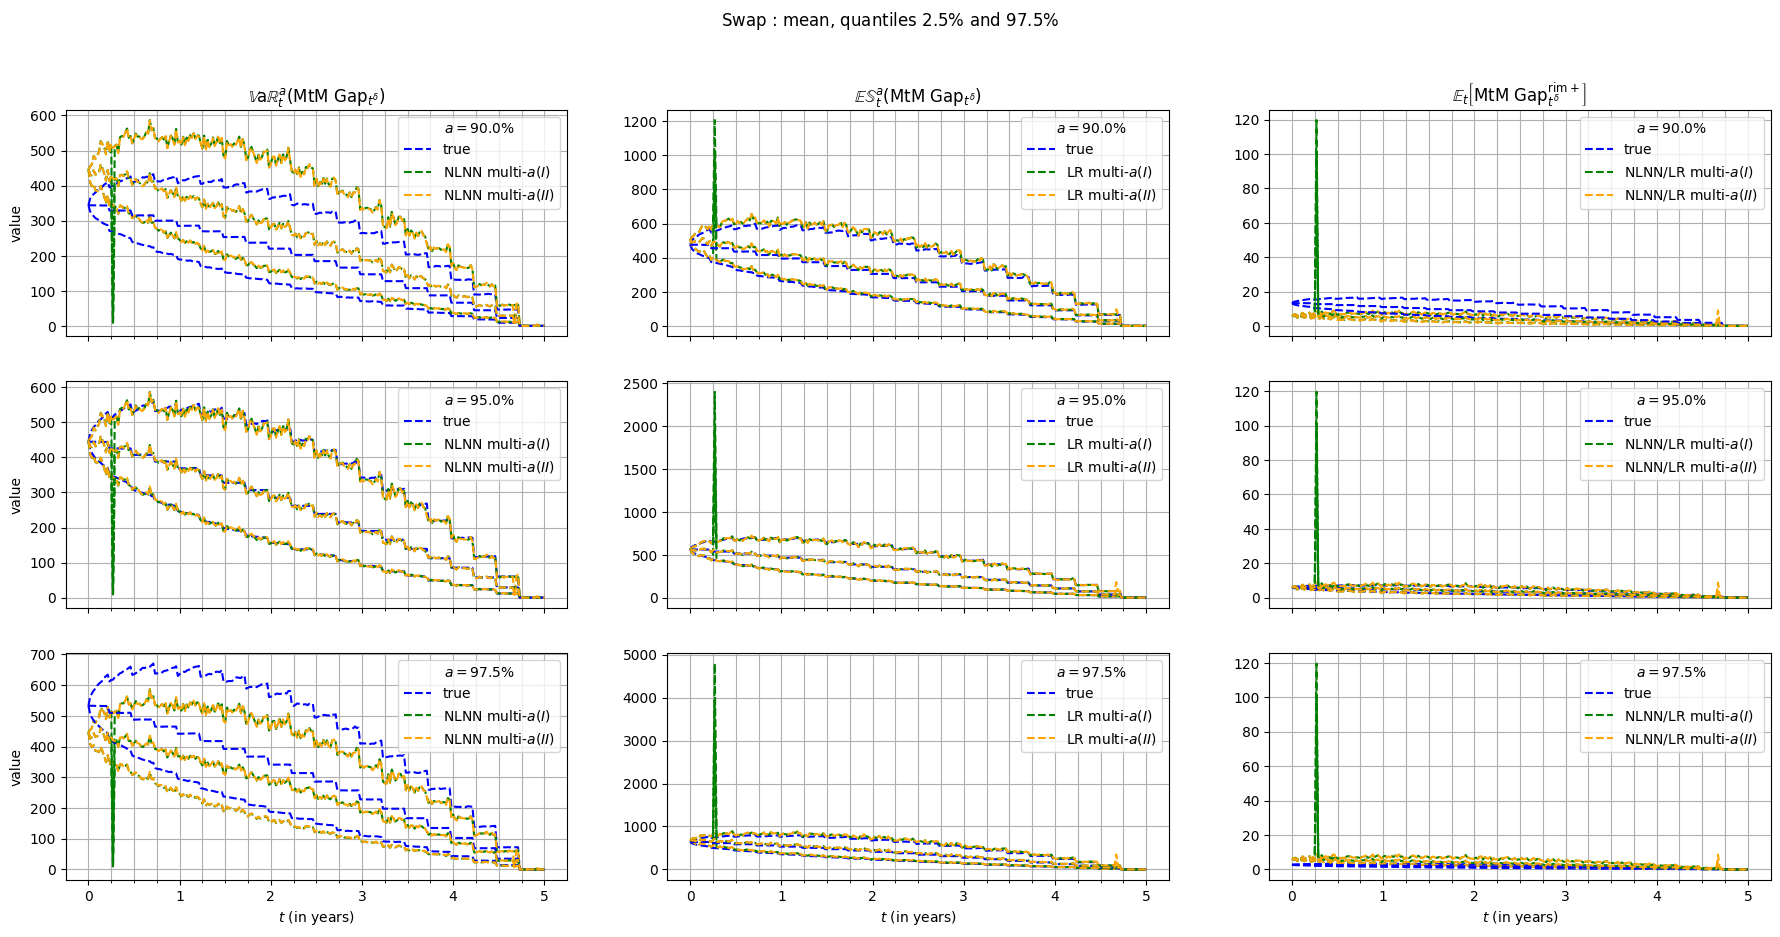

In [201]:
fig, axs = plt.subplots(figsize=(22, 10), ncols=3, nrows=len(a_vals), sharex=True)

def plot_fig(i, j, res1, res2, res3, lab1, lab2, lab3):
    axs[i, j].plot(time_grid, np.quantile(res1, 0.975, axis=0), label=lab1, linestyle='--', color='blue')
    axs[i, j].plot(time_grid, np.quantile(res2, 0.975, axis=0), label=lab2, linestyle='--', color='green')
    axs[i, j].plot(time_grid, np.quantile(res3, 0.975, axis=0), label=lab3, linestyle='--', color='orange')

    axs[i, j].plot(time_grid, np.quantile(res1, 0.025, axis=0), linestyle='--', color='blue')
    axs[i, j].plot(time_grid, np.quantile(res2, 0.025, axis=0), linestyle='--', color='green')
    axs[i, j].plot(time_grid, np.quantile(res3, 0.025, axis=0), linestyle='--', color='orange')

    axs[i, j].plot(time_grid, np.mean(res1, axis=0), linestyle='--', color='blue')
    axs[i, j].plot(time_grid, np.mean(res2, axis=0), linestyle='--', color='green')
    axs[i, j].plot(time_grid, np.mean(res3, axis=0), linestyle='--', color='orange')
    axs[i, j].set_xticks(swap_grid, minor=True)
    axs[i, j].grid(which='both')
    axs[i, j].legend(title=f'$a = ${a_vals[i]:.1%}')
    if j == 0:
        axs[i, j].set_ylabel('value')
    if i == len(a_vals)-1:
        axs[i, j].set_xlabel('$t$ (in years)')

for i, a_val in enumerate(a_vals):
    plot_fig(i, 0, var_mg_swap_mul_paths[:, :, i], var_mg_swap_nlnn_mul1_paths[:, :, i], var_mg_swap_nlnn_mul2_paths[:, :, i], 'true', 'NLNN multi-$a(I)$', 'NLNN multi-$a(II)$')
    plot_fig(i, 1, es_mg_swap_mul_paths[:, :, i], es_mg_swap_lr_mul1_paths[:, :, i], es_mg_swap_lr_mul2_paths[:, :, i], 'true', 'LR multi-$a(I)$', 'LR multi-$a(II)$')
    plot_fig(i, 2, econd_mgprim_swap_mul_paths[:, :, i], econd_MtMgaprim_swap_nlin_mul1_paths[:, :, i], econd_MtMgaprim_swap_nlin_mul2_paths[:, :, i], 'true', 'NLNN/LR multi-$a(I)$', 'NLNN/LR multi-$a(II)$')

axs[0, 0].set_title('$\\mathbb{V}\\text{a}\\mathbb{R}_t^a(\\text{MtM Gap}_{t^\\delta})$')
axs[0, 1].set_title('$\\mathbb{ES}_t^a(\\text{MtM Gap}_{t^\\delta})$')
axs[0, 2].set_title('$\\mathbb{E}_t\\left[\\text{MtM Gap}_{t^\\delta}^{\\text{rim} +}\\right]$')
        
plt.suptitle('Swap : mean, quantiles $2.5\\%$ and $97.5\\%$')
plt.show()



Unfortunately, whether it is multi-$\alpha(I)$ or multi-$\alpha(II)$, our methods are not working well. Indeed, we tend to overestimate the value-at-risk for high values of $a$ and underestimate it for low values of $a$. A similar behaviour is observed for the expected shortfall, producing very bad estimates of $\mathbb{E}_t\left[\text{MtM Gap}^{\text{rim} +}_{t^\delta}\right]$. Moreover, we obtain very similar results for the two multi-$\alpha$ approaches. It may be due to the fact that we did not standardize our features, and the neural network may be not sensitive enough to $a$ since its values are between $0$ and $1$. We have tried to standardize our data, but it led to huge divergence and oscillation effects in the results. With more samples, hyperparameter fine-tuning, a higher number of epochs, we believe could obtain better results.

Still, let's compute the estimated and true values of $\text{CVA}^{\text{rim}}_0$ for each $a$ and compare them.

In [202]:
for j, a_val in enumerate(a_vals):
    cvarim_swap_nlin_mul1   = calc_cva(econd_MtMgaprim_swap_nlin_mul1_paths[:, :, j])
    cvarim_swap_nlin_mul2   = calc_cva(econd_MtMgaprim_swap_nlin_mul2_paths[:, :, j])
    cvarim_swap_mc_mul      = calc_cva(econd_mgprim_swap_mul_paths[:, :, j])
    rho_vals                = (1-a_val) * (eta_vals - lambda_vals)
    c_vals                  = rho_vals[:-1]/(nom * np.exp(-kappa*time_grid[:-1]))
    cvarim_swap             = nom*S0*np.trapezoid(c_vals * np.exp(-gamma*time_grid[:-1]) * gamma, dx=delta)
    print(f"CVA swap formula ({a_val:.1%}): {cvarim_swap:.4f}")
    print(f"CVA swap using MC for outer expectation and formula for conditional expectation ({a_val:.1%}): {cvarim_swap_mc_mul:.4f}")
    print(f"CVA swap using MC for outer expectation and NLNN/LR multi-$\alpha(I)$ for conditional expectation ({a_val:.1%}): {cvarim_swap_nlin_mul1:.4f}")
    print(f"CVA swap using MC for outer expectation and NLNN/LR multi-$\alpha(II)$ for conditional expectation ({a_val:.1%}): {cvarim_swap_nlin_mul2:.4f}")
    print('-----------------------------------------------------------------------------------------------')

CVA swap formula (90.0%): 2.6637
CVA swap using MC for outer expectation and formula for conditional expectation (90.0%): 3.0011
CVA swap using MC for outer expectation and NLNN/LR multi-$lpha(I)$ for conditional expectation (90.0%): 1.5398
CVA swap using MC for outer expectation and NLNN/LR multi-$lpha(II)$ for conditional expectation (90.0%): 1.3727
-----------------------------------------------------------------------------------------------
CVA swap formula (95.0%): 1.3318
CVA swap using MC for outer expectation and formula for conditional expectation (95.0%): 1.3363
CVA swap using MC for outer expectation and NLNN/LR multi-$lpha(I)$ for conditional expectation (95.0%): 1.5415
CVA swap using MC for outer expectation and NLNN/LR multi-$lpha(II)$ for conditional expectation (95.0%): 1.3743
-----------------------------------------------------------------------------------------------
CVA swap formula (97.5%): 0.6659
CVA swap using MC for outer expectation and formula for conditi

We remark that our estimated CVA values are of the good magnitude only for $a=95\%$, which echoes the analysis done above.

## <span id="conclusion" style="color:#00B8DE"> Conclusion </span>

In this project, we have seen how to compute the CVA of a portfolio of derivatives with and without RIM. We used machine learning techniques to estimate the conditional expectations or conditional quantiles and expected shortfall involved in its computation. We have validated our results using different methods, such as twin Monte-Carlo trick and nested Monte-Carlo simulations, and we have shown that our estimations are close to the ground truth.